In [1]:
import math

import numpy as np
import qiskit.quantum_info
from sympy import *
import random
from qiskit import *
from qiskit import IBMQ
import pylatexenc
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
from IPython.display import clear_output
from numpy import linalg as la
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit import Parameter
from qiskit.compiler import transpile, assemble
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization import *
from operator import itemgetter
from functools import reduce
import pickle

In [24]:
file = open("key2.txt", "r")
key = file.read()
IBMQ.save_account(key, overwrite='True')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')
# provider = IBMQ.get_provider

print(provider.backends())

backendJakarta = provider.get_backend('ibmq_jakarta')
backendCasablanca = provider.get_backend('ibmq_casablanca')
backendQuito = provider.get_backend('ibmq_quito')
backendBelem = provider.get_backend('ibmq_belem')
backendQASM = provider.get_backend('ibmq_qasm_simulator')
# backend = provider.get_backend('simulator_statevector')
# simulator = Aer.get_backend('aer_simulator')
backend = backendJakarta
print(backend)
jobManager = IBMQJobManager()

ibmqfactory.load_account:WARNING:2021-11-30 03:11:24,649: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-research', group='michstate-4',

In [7]:
def deNone(value):
    return int(0 if value is None else value)


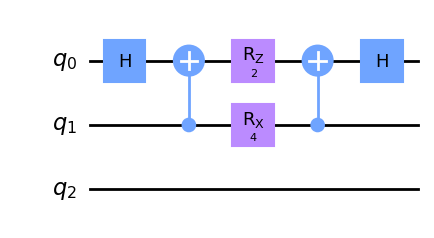

In [8]:
#turn on hadamards to get all 4 states present
def make_cont_sys_circ(inTime, xMod, zMod):
    temp = QuantumCircuit(3)

    temp.h(0)

    temp.cx(1, 0)

    temp.rx(2 * xMod * inTime, 1)
    temp.rz(2 * zMod * inTime, 0)

    temp.cx(1, 0)

    temp.h(0)

    return temp

temp = QuantumCircuit(3)

temp.compose(make_cont_sys_circ(1, 2, 1), [0, 1, 2], inplace=True)

temp.draw('mpl')

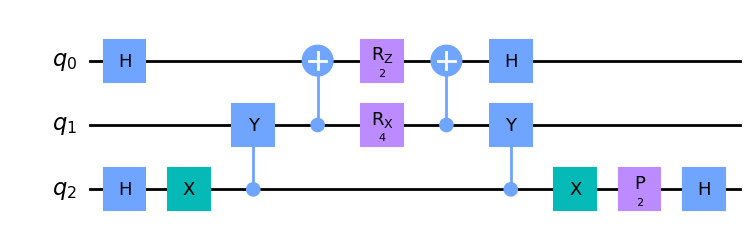

In [9]:
def make_cycle(time, ETarget, xMod, zMod):
    cycle = QuantumCircuit(3)

    cycle.h(2)

    cycle.x(2)
    cycle.cy(2, 1)

    cycle.compose(make_cont_sys_circ(time, xMod, zMod), [0, 1, 2], inplace=True)

    cycle.cy(2, 1)
    cycle.x(2)

    cycle.p(time * ETarget * 2, 2)

    cycle.h(2)

    return cycle

test = QuantumCircuit(3)
test.compose(make_cycle(1, 1, 2, 1), [0, 1, 2], inplace=True)
test.draw('mpl')

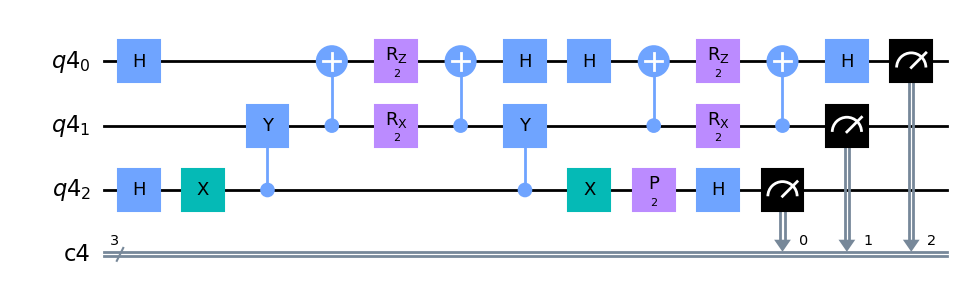

In [10]:
# measure z on 1 and x on 2 and multiply together to calculate "energy" expectation to find overlap amplitude
# do the opposite as well

# new method of transition matrix element calculation: measure observable for each state indiviually
def run_rodeo(times, numCycles, ETarget, xMod, zMod, twoStateTime = None, measureX = False, measure2 = False, measureSwap = False):
    # debug printing
    # if twoStateTime is None:
    #     print('running energy = ' + str(ETarget))
    # else:
    #     print('running energy = ' + str(ETarget) + '; second time evolve is: ' + str(twoStateTime))

    rodeo = QuantumCircuit(QuantumRegister(3), ClassicalRegister(numCycles + 1))
    if measure2 or measureSwap:
        rodeo = QuantumCircuit(QuantumRegister(3), ClassicalRegister(numCycles + 2))

    for i in range(numCycles):
        rodeo.compose(make_cycle(times[i], ETarget, xMod, zMod), [0, 1, 2], inplace=True)
        rodeo.measure(2, i)

    if twoStateTime is not None:
        rodeo.compose(make_cont_sys_circ(twoStateTime, xMod, zMod), [0, 1, 2], inplace=True)
        if measureX:
            rodeo.h(1)
        rodeo.measure(1, numCycles)

    if measure2:
        rodeo.measure(0, numCycles + 1)

    if measureSwap:
        rodeo.h(0)
        rodeo.measure(0, numCycles + 1)
        rodeo.measure(1, numCycles)

    return rodeo

cycleTest = run_rodeo([1], 1, 1, 1, 1, 1, False, True)
cycleTest.draw('mpl')


In [12]:
#TODO: make threshold rigorous

#TODO: split into 3 functions - 1 for each scan. Do analysis in seperate functions as well

def search_spectrum(linspace, threshold, numCycles, laterScanNum, numSecond, xMod, zMod, backend = provider.get_backend('ibmq_belem')):
    delta = abs(linspace[1]) - abs(linspace[0])
    length = linspace[0] - linspace[-1]

    runResults = list()
    energyList = list()

    state = ''
    for i in range(numCycles):
        state = state + '0'
    state = state + '0'

    peaks = list()
    firstRunCircs = list()
    for i in linspace:
        times = []
        for j in range(numCycles):
            times.append(np.random.normal(0, 2))
        firstRunCircs.append(run_rodeo(times, numCycles, i, xMod, zMod))
    print("first pass w/ energies")
    print(linspace)
    firstRunCircs = transpile(firstRunCircs, backend=backend)
    firstRunJob = jobManager.run(firstRunCircs, backend=backend, name = "first_pass")
    print("first run job id: " + firstRunJob.job_set_id())
    firstRunResults = firstRunJob.results()
    runResults.append(firstRunResults)
    energyList.append(linspace)

    for runNum in range(linspace.size):
        if firstRunResults.get_counts(runNum).get(state) is not None and firstRunResults.get_counts(runNum).get(state) >= threshold:
            peaks.append(linspace[runNum])
    print("second pass w/ peaks:")
    print(peaks)

    secondRunCircs = list()
    energyList.append([])
    for i in peaks:
        for j in np.linspace(i - delta/2, i + delta/2, laterScanNum):
            for num in range(numSecond):
                times = []
                for k in range(numCycles):
                    times.append(np.random.normal(0, 7))
                # print('energy: ' + str(j))
                secondRunCircs.append(run_rodeo(times, numCycles, j, xMod, zMod))
                energyList[1].append(j)

    secondRunCircs = transpile(secondRunCircs, backend=backend)
    secondRunJob = jobManager.run(secondRunCircs, backend=backend, name = "second_run")
    print("second run job id: " + secondRunJob.job_set_id())

    runResults.append(secondRunJob.results())
    print("done w/ second pass")

    #third scan algorithm: go through each energy. if it is above 200, a peak is there. If the next scan is greater, update the peak location. End peak when the next scan is below 200. Repeat for all scans

    return [runResults, energyList, state, [11, laterScanNum], [1, numSecond]]

In [13]:
#this code is genuinely terrible, but it works
#runNumber is 0 indexed
def process_data(output, runNumber):
    pairArray = []
    for i in range(int(len(output[1][runNumber]) / (output[4][runNumber]))):
        totalSuccess = 0
        for j in range(output[4][runNumber]):
            if output[0][runNumber].get_counts(i * output[4][runNumber] + j).get(output[2]) is not None:
                totalSuccess = totalSuccess + output[0][runNumber].get_counts(i * output[4][runNumber] + j).get(output[2])
        pairArray.append([output[1][runNumber][i * output[4][runNumber]], totalSuccess / output[4][runNumber]])

    subScans = []
    for i in range(int(len(pairArray) / output[3][runNumber])):
        temp = []
        for k in range(output[3][runNumber]):
            temp.append(pairArray[k + i * output[3][runNumber]])
        temp.reverse()
        subScans.append(temp)
    return subScans

In [14]:
def plot_scans(data):
    energy = []
    successes = []
    for i in data:
        for j in i:
            energy.append(j[0])
            if j[1] is not None:
                successes.append(j[1])

    hist1 = plt.bar(energy, successes, width=(0.8*(energy[1]-energy[0])))
    plt.show()

In [15]:
def process_two_state(results, state):
    totals = list()
    counts = list()
    expectations = list()

    states = [state, '1' + state[:-1]]

    for i in range(100):
        temp = deNone(results.get_counts(i).get(states[0]))
        temp = temp + deNone(results.get_counts(i).get(states[1]))

        totals.append(temp)

    for i in range(100):
        counts.append(deNone(results.get_counts(i).get(state)))

    for i in range(100):
        expectations.append(counts[i]/totals[i] * (-0.5) + (1-counts[i]/totals[i]) * 0.5)

    print(totals)
    return expectations

In [16]:
def process_two_state_dual(results, state):
    totals = list()
    countsUpper = list()
    countsLower = list()
    expectations = list()

    #first index is upper, second is lower
    # 0 for upper and lower, 0 for upper 1 for lower, 1 for upper 0 for lower, 1 for upper 1 for lower
    states = [state, '01' + state[:-1][:-1], '10' + state[:-1][:-1], '11' + state[:-1][:-1]]

    for i in range(100):
        temp = deNone(results.get_counts(i).get(states[0]))
        temp = temp + deNone(results.get_counts(i).get(states[1]))
        temp = temp + deNone(results.get_counts(i).get(states[2]))
        temp = temp + deNone(results.get_counts(i).get(states[3]))
        totals.append(temp)

    for i in range(100):
        # append all 0 (00000) (lower down, upper down) and 1 at start (10000) (lower down, upper up)
        countsLower.append(deNone(results.get_counts(i).get(state)) + deNone(results.get_counts(i).get(states[2])))
        # append all 0 (00000) (lower down, upper down) and 1 at end (00001) (lower up, upper down)
        countsUpper.append(deNone(results.get_counts(i).get(state)) + deNone(results.get_counts(i).get(states[1])))

    for i in range(100):
        tempExpect = countsLower[i]/totals[i] * (-0.5) + (1-countsLower[i]/totals[i]) * 0.5
        tempExpect = tempExpect + countsUpper[i]/totals[i] * (-0.5) + (1-countsUpper[i]/totals[i]) * 0.5
        expectations.append(tempExpect)


    print(totals)
    return expectations

In [17]:
def run_two_state(cycles, secondTimes, xMod, zMod, lowTarget, highTarget, backend = provider.get_backend('ibmq_belem'), measureX = False, measure2 = False):
    times = list()
    for i in range(cycles):
        tempTime = round(np.random.normal(0, 5))
        if tempTime == 0:
            tempTime = (-1)^random.randint(0, 1)
        times.append(tempTime * 2 * 3.1415926 / (lowTarget - highTarget))
    times = [10.0531, 1.25664, 5.02655]
    circs = list()
    for i in secondTimes:
        circs.append(run_rodeo(times, cycles, lowTarget, xMod, zMod, i, measureX, measure2))

    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, name="two_state")

    return job

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-4.0, -1.0, 2.0, 4.0, 5.0]
done w/ second pass
2
[[[-4.5, 88.44], [-4.45, 147.12], [-4.4, 117.24], [-4.35, 119.32], [-4.3, 143.84], [-4.25, 99.52], [-4.2, 114.64], [-4.15, 187.32], [-4.1, 82.8], [-4.05, 145.68], [-4.0, 168.24], [-3.95, 132.24], [-3.9, 169.0], [-3.85, 142.16], [-3.8, 79.76], [-3.75, 123.36], [-3.7, 120.84], [-3.65, 122.28], [-3.6, 145.12], [-3.55, 142.92], [-3.5, 88.2]], [[-1.5, 148.44], [-1.4500000000000002, 168.0], [-1.4, 160.12], [-1.35, 142.64], [-1.3, 119.52], [-1.25, 164.48], [-1.2000000000000002, 104.84], [-1.15, 160.64], [-1.1, 205.08], [-1.05, 457.28], [-1.0, 616.48], [-0.95, 415.48], [-0.9, 216.08], [-0.8500000000000001, 145.44], [-0.8, 127.8], [-0.75, 60.36], [-0.7, 129.16], [-0.65, 160.24], [-0.6, 92.6], [-0.55, 112.6], [-0.5, 144.76]], [[1.5, 147.04], [1.5499999999999998, 194.48], [1.6, 94.68], [1.65, 144.88], [1.7, 148.24], [1.75, 100.08], [1.7999999999999998, 172.2

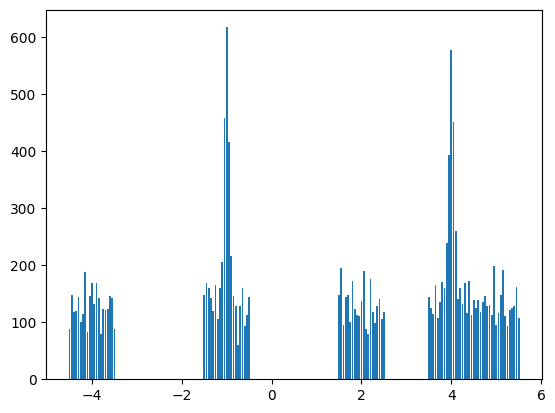

In [14]:
threeCycleOut = search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5)
# print(threeCycleOut)
print(len(threeCycleOut[1][1]))
threeCycle2 = process_data(threeCycleOut, 1)
print(threeCycle2)

plot_scans(threeCycle2)

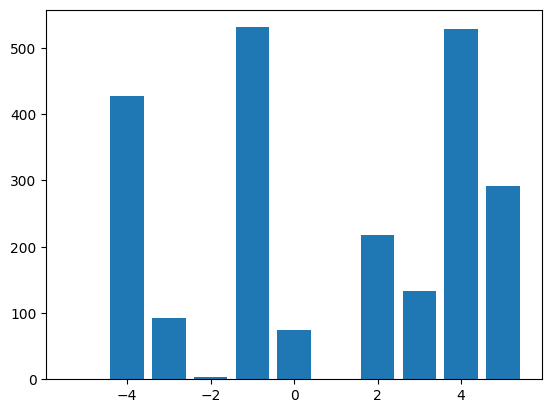

In [15]:
threeCycle1 = process_data(threeCycleOut, 0)
plot_scans(threeCycle1)

In [12]:
xmod1 = 1#.3359430644
zmod1 = 2.7803609513

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-2.0, 0.0, 2.0, 3.0, 4.0, 5.0]
done w/ second pass
[[[-2.5, 140.52], [-2.45, 151.12], [-2.4, 174.28], [-2.35, 101.96], [-2.3, 79.08], [-2.25, 131.04], [-2.2, 117.12], [-2.15, 127.08], [-2.1, 120.2], [-2.05, 114.64], [-2.0, 109.2], [-1.95, 113.96], [-1.9, 157.6], [-1.85, 154.84], [-1.8, 162.96], [-1.75, 205.48], [-1.7, 138.24], [-1.65, 119.72], [-1.6, 142.76], [-1.55, 175.4], [-1.5, 107.28]], [[-0.5, 79.0], [-0.45000000000000007, 71.92], [-0.4, 146.88], [-0.3500000000000001, 97.8], [-0.30000000000000004, 120.96], [-0.25, 127.6], [-0.20000000000000007, 100.96], [-0.15000000000000002, 112.64], [-0.10000000000000009, 119.56], [-0.050000000000000044, 118.64], [0.0, 126.76], [0.04999999999999999, 132.92], [0.09999999999999998, 104.52], [0.14999999999999997, 156.72], [0.19999999999999996, 111.4], [0.25, 66.16], [0.3, 110.8], [0.35, 149.96], [0.4, 114.0], [0.45, 112.44], [0.5, 124.92]], [[1.5, 120.52], 

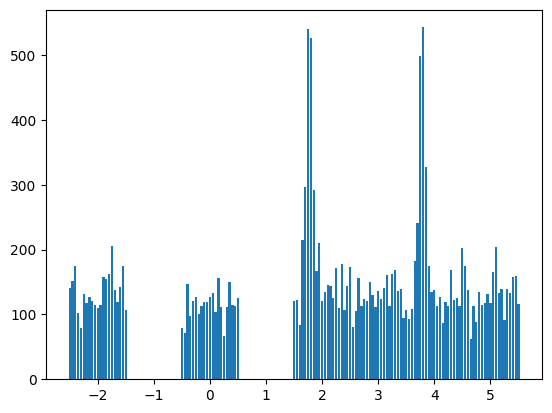

In [18]:
randomTest = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTest)
plot_scans(randomTest)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-5.0, -2.0, -1.0, 2.0, 3.0, 4.0, 5.0]


managedjob._async_submit:WARNING:2021-10-22 15:10:56,110: Job limit reached, waiting for job 61730cb5731fe680eebce245 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:13:57,821: Job limit reached, waiting for job 61730cb8976ff9693281c634 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:14:28,294: Job limit reached, waiting for job 61730cba976ff983b481c635 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:14:56,945: Job limit reached, waiting for job 61730cbc976ff9bfea81c636 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:15:29,063: Job limit reached, waiting for job 61730cbe706f42c99d432c01 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:15:59,461: Job limit reached, waiting for job 61730d73731fe6551cbce24a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10

done w/ second pass
[[[-5.5, 129.12], [-5.45, 165.8], [-5.4, 127.2], [-5.35, 111.0], [-5.3, 124.8], [-5.25, 130.16], [-5.2, 144.2], [-5.15, 144.24], [-5.1, 171.32], [-5.05, 141.12], [-5.0, 156.4], [-4.95, 146.72], [-4.9, 127.2], [-4.85, 131.16], [-4.8, 120.8], [-4.75, 127.8], [-4.7, 153.56], [-4.65, 135.88], [-4.6, 134.36], [-4.55, 123.16], [-4.5, 144.32]], [[-2.5, 149.16], [-2.45, 147.88], [-2.4, 108.6], [-2.35, 149.48], [-2.3, 155.72], [-2.25, 114.36], [-2.2, 148.56], [-2.15, 147.96], [-2.1, 133.28], [-2.05, 172.88], [-2.0, 112.44], [-1.95, 113.52], [-1.9, 124.64], [-1.85, 134.32], [-1.8, 166.96], [-1.75, 185.36], [-1.7, 168.2], [-1.65, 139.52], [-1.6, 169.16], [-1.55, 105.76], [-1.5, 129.2]], [[-1.5, 138.36], [-1.4500000000000002, 135.2], [-1.4, 142.44], [-1.35, 132.88], [-1.3, 120.6], [-1.25, 151.44], [-1.2000000000000002, 165.28], [-1.15, 119.56], [-1.1, 154.08], [-1.05, 113.72], [-1.0, 153.44], [-0.95, 148.28], [-0.9, 130.16], [-0.8500000000000001, 160.4], [-0.8, 165.08], [-0.75,

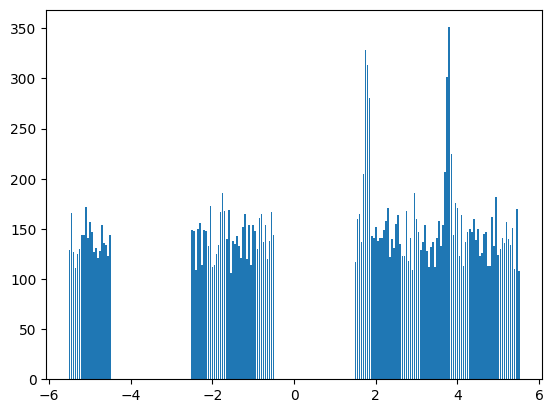

In [20]:
randomTestQ = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestQ)
plot_scans(randomTestQ)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-4.0, -2.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0]


managedjob._async_submit:WARNING:2021-10-24 00:52:39,735: Job limit reached, waiting for job 6174e68d731fe62419bcf1b5 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:53:14,194: Job limit reached, waiting for job 6174e68f706f426d59433b60 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:53:43,384: Job limit reached, waiting for job 6174e6909e07dd733b57995b to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:54:11,400: Job limit reached, waiting for job 6174e6924829a00a7616262b to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:54:39,980: Job limit reached, waiting for job 6174e6946ab940b0d710ed9d to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:55:08,083: Job limit reached, waiting for job 6174e6b69e07ddb09257995d to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10

done w/ second pass
[[[-4.5, 250.92], [-4.45, 243.44], [-4.4, 314.52], [-4.35, 259.6], [-4.3, 207.16], [-4.25, 302.76], [-4.2, 245.92], [-4.15, 274.44], [-4.1, 253.52], [-4.05, 262.0], [-4.0, 271.2], [-3.95, 251.2], [-3.9, 230.48], [-3.85, 270.8], [-3.8, 267.64], [-3.75, 298.68], [-3.7, 298.36], [-3.65, 244.88], [-3.6, 209.24], [-3.55, 329.04], [-3.5, 336.72]], [[-2.5, 273.36], [-2.45, 258.12], [-2.4, 312.72], [-2.35, 316.96], [-2.3, 323.68], [-2.25, 266.4], [-2.2, 261.72], [-2.15, 283.08], [-2.1, 297.24], [-2.05, 280.36], [-2.0, 241.08], [-1.95, 275.68], [-1.9, 243.16], [-1.85, 281.92], [-1.8, 287.96], [-1.75, 253.88], [-1.7, 226.16], [-1.65, 278.4], [-1.6, 282.16], [-1.55, 314.64], [-1.5, 262.12]], [[-1.5, 243.6], [-1.4500000000000002, 256.92], [-1.4, 333.04], [-1.35, 290.84], [-1.3, 301.04], [-1.25, 270.52], [-1.2000000000000002, 282.64], [-1.15, 264.28], [-1.1, 310.84], [-1.05, 277.12], [-1.0, 328.56], [-0.95, 308.56], [-0.9, 262.68], [-0.8500000000000001, 316.16], [-0.8, 243.32], 

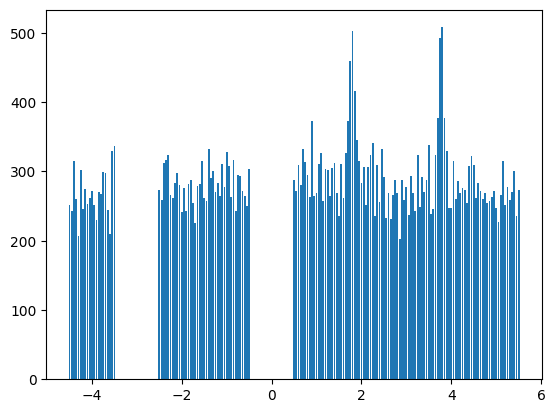

In [12]:
randomTestQ2 = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 2, 21, 25, xmod1, zmod1), 1)
print(randomTestQ2)
plot_scans(randomTestQ2)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-5.0, -2.0, 0.0, 1.0, 2.0, 4.0]
done w/ second pass
[[[-5.5, 122.76], [-5.45, 143.56], [-5.4, 101.76], [-5.35, 159.52], [-5.3, 137.76], [-5.25, 123.12], [-5.2, 136.6], [-5.15, 147.0], [-5.1, 116.64], [-5.05, 156.88], [-5.0, 127.36], [-4.95, 125.4], [-4.9, 183.44], [-4.85, 139.28], [-4.8, 120.8], [-4.75, 123.8], [-4.7, 145.48], [-4.65, 96.32], [-4.6, 136.36], [-4.55, 108.64], [-4.5, 111.08]], [[-2.5, 112.84], [-2.45, 161.72], [-2.4, 121.68], [-2.35, 142.88], [-2.3, 106.36], [-2.25, 107.32], [-2.2, 135.8], [-2.15, 106.4], [-2.1, 172.64], [-2.05, 99.44], [-2.0, 143.36], [-1.95, 123.12], [-1.9, 147.0], [-1.85, 100.64], [-1.8, 164.6], [-1.75, 174.52], [-1.7, 159.52], [-1.65, 137.04], [-1.6, 134.88], [-1.55, 139.6], [-1.5, 143.48]], [[-0.5, 108.84], [-0.45000000000000007, 147.24], [-0.4, 120.4], [-0.3500000000000001, 149.56], [-0.30000000000000004, 110.28], [-0.25, 116.52], [-0.20000000000000007, 152.

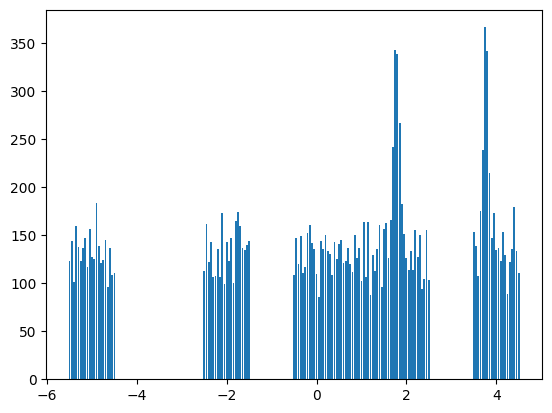

In [19]:
randomTestCasablanca = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestCasablanca)
plot_scans(randomTestCasablanca)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-3.0, 1.0, 2.0, 3.0, 4.0, 5.0]
done w/ second pass
[[[-3.5, 166.32], [-3.45, 106.68], [-3.4, 131.28], [-3.35, 173.36], [-3.3, 144.44], [-3.25, 114.56], [-3.2, 136.72], [-3.15, 149.04], [-3.1, 111.2], [-3.05, 121.4], [-3.0, 104.16], [-2.95, 127.12], [-2.9, 136.4], [-2.85, 131.96], [-2.8, 113.72], [-2.75, 99.44], [-2.7, 132.6], [-2.65, 99.88], [-2.6, 126.16], [-2.55, 118.24], [-2.5, 128.72]], [[0.5, 141.76], [0.5499999999999999, 141.52], [0.6, 151.96], [0.6499999999999999, 122.8], [0.7, 163.12], [0.75, 110.72], [0.7999999999999999, 127.44], [0.85, 178.0], [0.8999999999999999, 117.36], [0.95, 150.72], [1.0, 104.96], [1.05, 129.52], [1.1, 137.04], [1.15, 153.0], [1.2, 166.84], [1.25, 134.92], [1.3, 177.8], [1.35, 118.92], [1.4, 121.4], [1.45, 133.76], [1.5, 140.04]], [[1.5, 124.32], [1.5499999999999998, 140.92], [1.6, 157.4], [1.65, 210.48], [1.7, 220.44], [1.75, 320.16], [1.7999999999999998, 347.8]

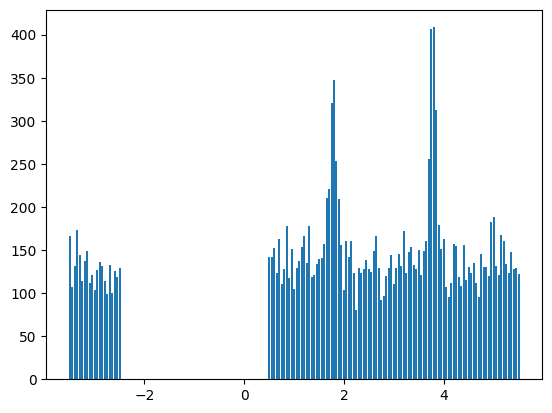

In [21]:
randomTestJakarta = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestJakarta)
plot_scans(randomTestJakarta)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[2.0, 4.0]
done w/ second pass
[[<qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677D7C5340>, <qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677E781880>], [array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]), [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 

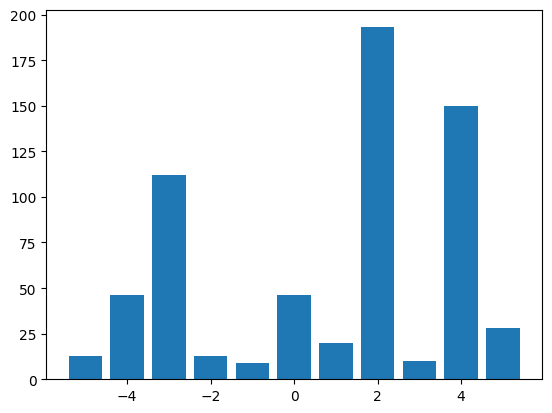

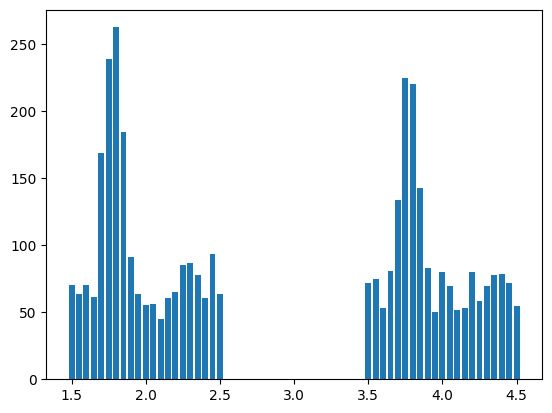

In [14]:
randomTestJakarta4Cycle = search_spectrum(np.linspace(-5, 5, 11), 150, 4, 21, 25, xmod1, zmod1)
randomTestJakarta4CycleInitial = process_data(randomTestJakarta4Cycle, 0)
randomTestJakarta4CycleFinal = process_data(randomTestJakarta4Cycle, 1)
print(randomTestJakarta4Cycle)
plot_scans(randomTestJakarta4CycleInitial)
plot_scans(randomTestJakarta4CycleFinal)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-2.0, -1.0, 2.0, 4.0]
done w/ second pass
[[<qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677EA93AC0>, <qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002671AF84D60>], [array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]), [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65

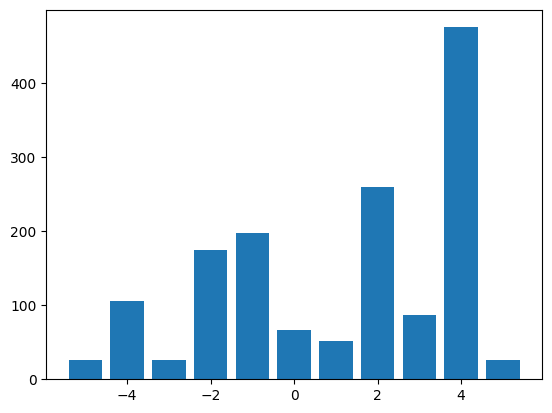

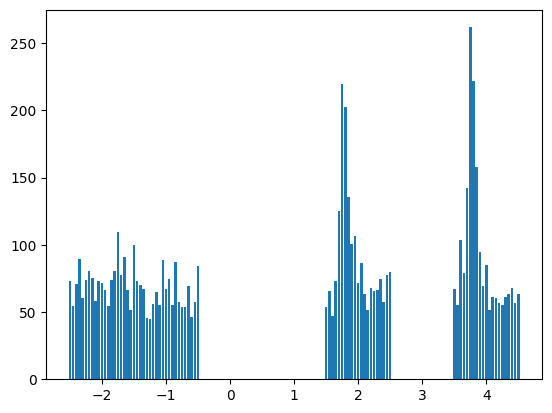

In [15]:
randomTestJakarta4Cycle2 = search_spectrum(np.linspace(-5, 5, 11), 150, 4, 21, 25, xmod1, zmod1)
randomTestJakarta4CycleInitial2 = process_data(randomTestJakarta4Cycle2, 0)
randomTestJakarta4CycleFinal2 = process_data(randomTestJakarta4Cycle2, 1)
print(randomTestJakarta4Cycle2)
plot_scans(randomTestJakarta4CycleInitial2)
plot_scans(randomTestJakarta4CycleFinal2)



In [24]:
fourRange = list(range(100))
fourRange[:] = [x / 25 for x in fourRange]

# fourJob = run_two_state(3, fourRange, 2.5, 1.5, -1, 4)
fourJob = jobManager.retrieve_job_set('eb379bacddad4a89a4efef94e987f0bd-1636140982352417', provider)
print(fourJob.job_set_id())
fourResults = fourJob.results()

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjobset.py:195: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  experiments_count=len(job.qobj().experiments),


eb379bacddad4a89a4efef94e987f0bd-1636140982352417


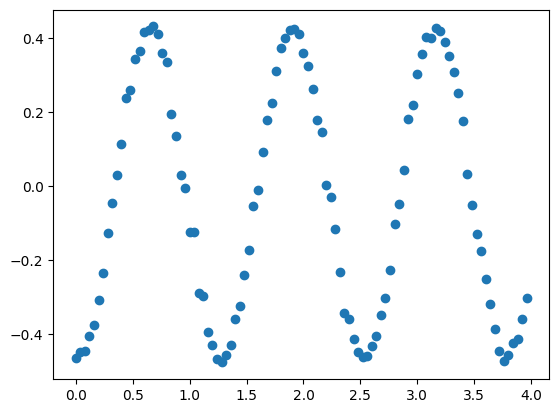

In [15]:
plt.scatter(fourRange, process_two_state(fourResults, "0000"))
plt.show()

In [28]:
fourJob2 = run_two_state(3, fourRange, 2.5, 1.5, -1, 4)
print(fourJob2.job_set_id())
fourResults2 = fourJob2.results()

14fc1ae7d2494aa3850c76af70c4d411-16376708627117543


[435, 412, 453, 409, 422, 443, 400, 407, 400, 430, 415, 405, 439, 410, 422, 425, 386, 419, 407, 392, 422, 452, 420, 420, 456, 432, 387, 430, 443, 415, 435, 403, 428, 417, 415, 439, 418, 424, 443, 407, 418, 426, 401, 419, 437, 421, 415, 409, 389, 414, 422, 412, 395, 431, 426, 417, 414, 455, 404, 413, 402, 405, 410, 439, 441, 395, 416, 429, 401, 410, 398, 400, 438, 407, 421, 427, 445, 428, 407, 425, 410, 404, 406, 414, 416, 409, 426, 399, 434, 418, 429, 414, 406, 412, 407, 441, 417, 429, 427, 418]


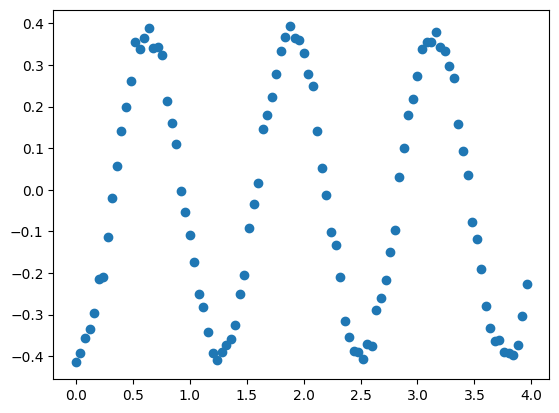

In [30]:
plt.scatter(fourRange, process_two_state(fourResults2, "0000"))
plt.show()

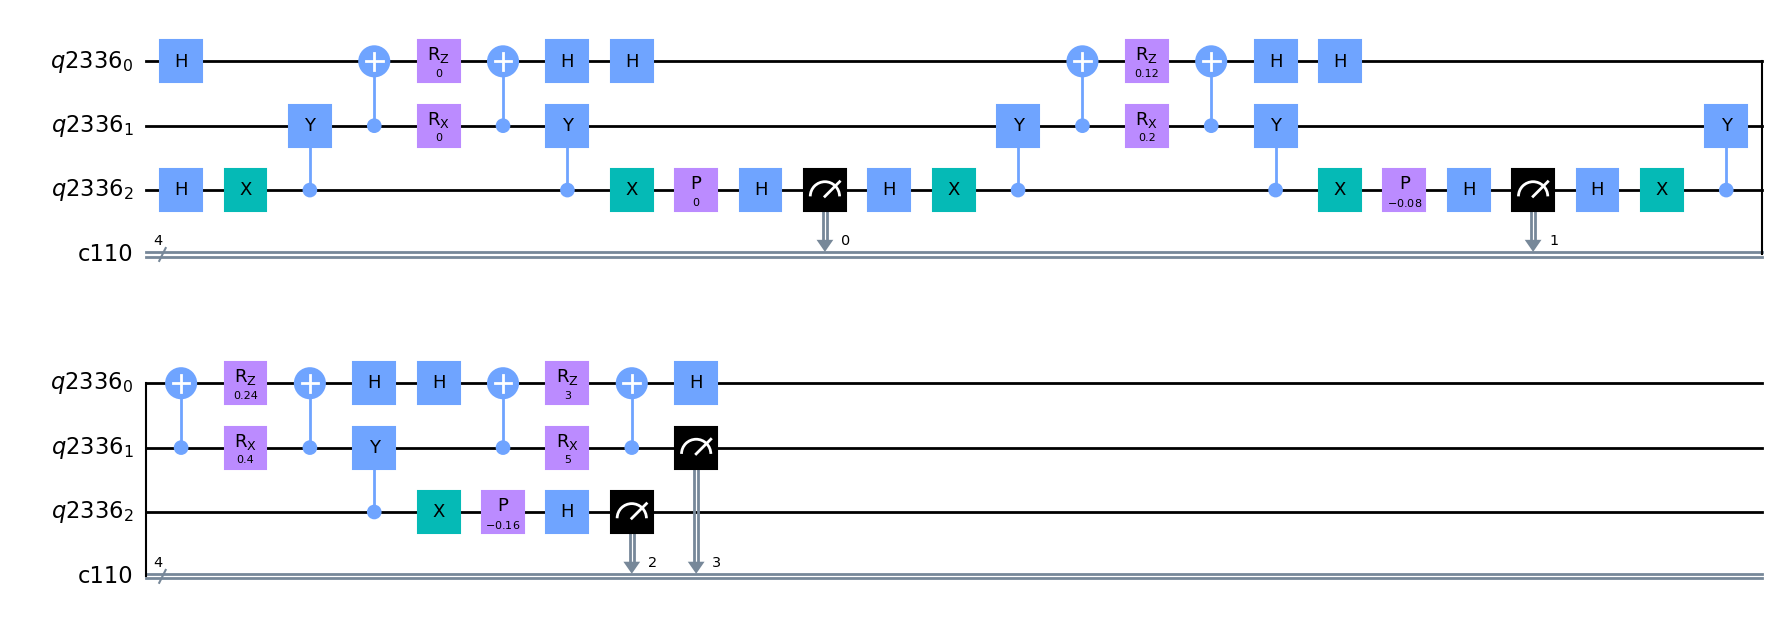

In [29]:
circ = run_rodeo(fourRange, 3, -1, 2.5, 1.5, 1)
circ.draw('mpl')

In [31]:
run1Range = list(range(100))
run1Range[:] = [x / 10 for x in run1Range]

# run1Job = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
run1Job = jobManager.retrieve_job_set('0113f01d576942539ef3e6db95e581ca-1636258522398855', provider)
print(run1Job.job_set_id())
run1Results = run1Job.results()

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjobset.py:195: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  experiments_count=len(job.qobj().experiments),


0113f01d576942539ef3e6db95e581ca-1636258522398855


[-0.4662921348314607, -0.42911392405063287, -0.27142857142857146, -0.04225352112676062, 0.2071428571428571, 0.3619854721549637, 0.44063926940639275, 0.4282296650717703, 0.2780487804878049, 0.10563380281690146, -0.08392434988179664, -0.33114035087719296, -0.45707070707070707, -0.4634703196347032, -0.3443396226415094, -0.1772616136919315, 0.04952830188679247, 0.24634146341463414, 0.3886138613861386, 0.4250585480093677, 0.3906605922551253, 0.19194312796208532, -0.001187648456057011, -0.19844789356984482, -0.38809523809523805, -0.4578454332552693, -0.42396313364055305, -0.31861575178997614, -0.06896551724137934, 0.1244343891402715, 0.33521444695259595, 0.42700729927007297, 0.42592592592592593, 0.3089887640449438, 0.14186046511627912, -0.07894736842105265, -0.3009367681498829, -0.42874109263657956, -0.458128078817734, -0.3789346246973365, -0.19047619047619047, 0.04629629629629628, 0.2396061269146608, 0.3883720930232558, 0.44736842105263164, 0.41034482758620694, 0.22817955112219448, 0.004587

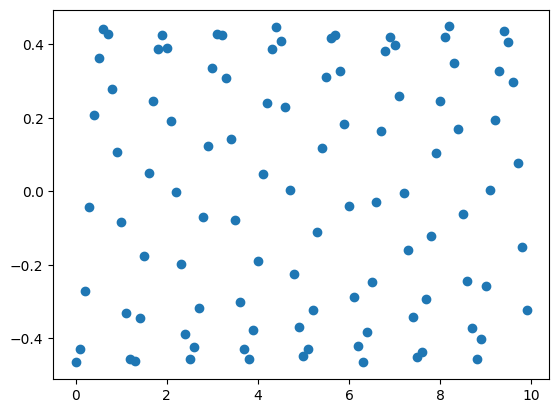

In [20]:
print(process_two_state(run1Results, "0000"))
plt.scatter(run1Range, process_two_state(run1Results, "0000"))
plt.show()

In [24]:
#run with hadamard on 1st qubit for time evolution; bad data
run2Range = list(range(100))
run2Range[:] = [x / 10 for x in run2Range]

run2Job = run_two_state(3, run2Range, 2.5, 1.5, 1, 4, backendJakarta)
print(run2Job.job_set_id())
run2Results = run2Job.results()

d453bb67ce3f45aa8ada23f0ddac1426-16362952522716198


[-0.46445497630331756, -0.4451371571072319, -0.3811369509043928, -0.2766990291262136, -0.19417475728155342, -0.06521739130434778, 0.057213930348258724, 0.18226600985221675, 0.3045977011494253, 0.408641975308642, 0.41183879093198994, 0.42091836734693877, 0.3987341772151899, 0.3163265306122449, 0.2153846153846154, 0.09114583333333329, -0.08968058968058967, -0.15159574468085102, -0.2931034482758621, -0.38916256157635465, -0.43041237113402064, -0.4362244897959183, -0.4363867684478372, -0.38601036269430056, -0.3075, -0.1633663366336634, -0.04707379134860046, 0.10447761194029856, 0.2021276595744681, 0.29104477611940305, 0.37760416666666663, 0.39973614775725597, 0.4285714285714286, 0.3850855745721271, 0.2777777777777778, 0.17766497461928932, 0.06973995271867614, -0.08695652173913049, -0.15263157894736845, -0.30052493438320205, -0.35121951219512193, -0.4251870324189526, -0.45663265306122447, -0.4151670951156813, -0.3307692307692308, -0.3112244897959183, -0.2132530120481928, -0.0808823529411765

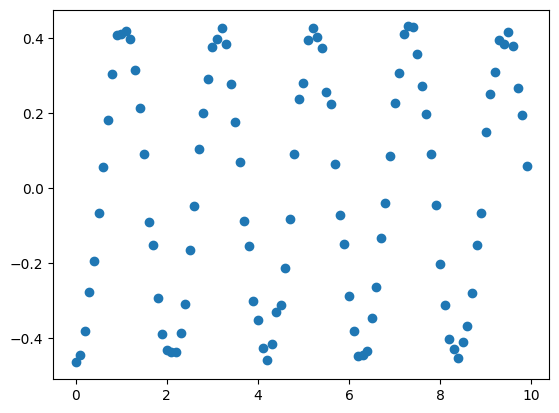

In [25]:
#run with hadamard on 1st qubit for time evolution; bad data
print(process_two_state(run2Results, "0000"))
plt.scatter(run2Range, process_two_state(run2Results, "0000"))
plt.show()

In [27]:
run3Range = list(range(100))
run3Range[:] = [x / 10 for x in run3Range]

run3Job = run_two_state(3, run3Range, 2.5, 1.5, 1, 4, backendCasablanca)
print(run3Job.job_set_id())
run3Results = run3Job.results()

e68c0f9ee75a4bc688bd5773baa84cb5-1636295587006089


[0.09999999999999998, -0.025925925925925908, -0.026717557251908386, -0.017985611510791366, -0.020270270270270285, -0.03076923076923077, 0.0, -0.05737704918032782, 0.04263565891472873, -0.011450381679389277, -0.06944444444444442, -0.02941176470588236, -0.0798319327731093, 0.02941176470588236, -0.05639097744360899, 0.017730496453900707, -0.07046979865771807, -0.0037037037037036535, -0.023809523809523836, -0.020325203252032575, -0.011811023622047223, -0.07241379310344831, -0.03125, -0.021739130434782594, -0.08461538461538465, -0.0703125, -0.05147058823529416, 0.02517985611510795, -0.020000000000000018, 0.0, 0.04014598540145986, 0.018796992481203034, 0.024590163934426257, -0.02941176470588236, -0.04014598540145986, -0.04744525547445255, -0.10483870967741937, -0.06060606060606055, 0.038461538461538436, 0.044378698224852076, 0.14347826086956525, -0.04471544715447151, 0.057046979865771785, -0.026717557251908386, 0.02892561983471076, -0.0234375, -0.011811023622047223, -0.0855855855855856, -0.0

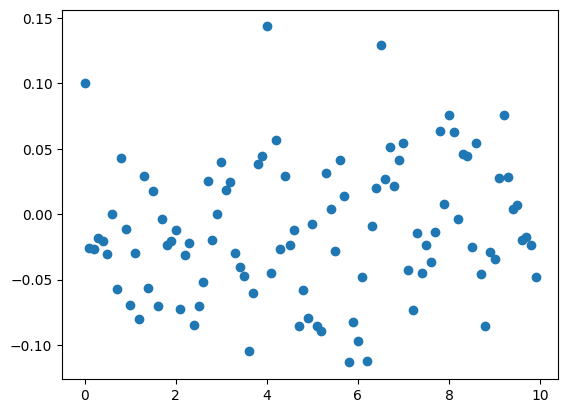

In [28]:
print(process_two_state(run3Results, "0000"))
plt.scatter(run3Range, process_two_state(run3Results, "0000"))
plt.show()

In [35]:
run4Job1Cycle = run_two_state(1, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job1Cycle.job_set_id())
run41CycleResults = run4Job1Cycle.results()

run4Job2Cycle = run_two_state(2, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job2Cycle.job_set_id())
run42CycleResults = run4Job2Cycle.results()

run4Job3Cycle = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job3Cycle.job_set_id())
run43CycleResults = run4Job3Cycle.results()

run4Job4Cycle = run_two_state(4, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job4Cycle.job_set_id())
run44CycleResults = run4Job4Cycle.results()

10faa0f1091d47449b460a910ca6f038-1636297440729653
8c64b883b944451599ff6287a1215316-1636297529660125
3eadafa198e248de891631d862105eb4-16362975861800056
175939a699f14141b8956b96c21e6ab5-16362976478864727


[-0.48080614203454897, -0.40751445086705207, -0.25183823529411764, -0.012670565302144277, 0.2288461538461539, 0.36837294332723947, 0.4343629343629344, 0.40858208955223885, 0.23567467652495377, 0.024436090225563922, -0.19739478957915835, -0.376425855513308, -0.46953405017921146, -0.44609665427509293, -0.31056466302367947, -0.12407407407407411, 0.11481481481481481, 0.30996309963099633, 0.428698752228164, 0.42871287128712876, 0.3349514563106796, 0.14165103189493433, -0.08674463937621835, -0.25806451612903225, -0.43398058252427185, -0.48378378378378384, -0.3809946714031972, -0.25529865125240847, -0.051656920077972734, 0.17041198501872665, 0.3798449612403101, 0.4444444444444444, 0.41204588910133844, 0.26717557251908397, 0.05555555555555558, -0.16666666666666663, -0.35144927536231885, -0.4595375722543352, -0.4467680608365019, -0.3176691729323309, -0.17463235294117652, 0.07090909090909092, 0.2657142857142857, 0.412621359223301, 0.43482309124767227, 0.34980237154150196, 0.13068181818181815, -0

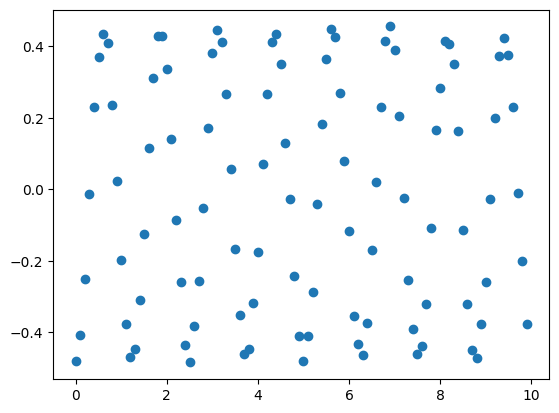

In [41]:
print(process_two_state(run41CycleResults, "00"))
plt.scatter(run3Range, process_two_state(run41CycleResults, "00"))
plt.show()

[-0.47836166924265844, -0.4296407185628742, -0.323170731707317, -0.09829059829059827, 0.12462006079027355, 0.2840579710144928, 0.4532428355957767, 0.4329268292682926, 0.34259259259259256, 0.09907120743034056, -0.09398496240601506, -0.31008902077151335, -0.4370314842578711, -0.4687034277198212, -0.3802395209580839, -0.2305389221556886, 0.008371385083713906, 0.2360482654600302, 0.3734567901234568, 0.44298921417565484, 0.3830409356725146, 0.23806078147612156, 0.038226299694189586, -0.17391304347826086, -0.3748137108792846, -0.46711509715994026, -0.4499241274658573, -0.31818181818181823, -0.11180124223602483, 0.09848484848484851, 0.31060606060606055, 0.420704845814978, 0.4323899371069182, 0.35053929121725735, 0.13931888544891644, -0.09661495063469672, -0.3130699088145896, -0.41594202898550725, -0.4709480122324159, -0.3923766816143498, -0.25113808801213966, -0.03055141579731746, 0.20044052863436124, 0.3533333333333333, 0.4420970266040689, 0.3973607038123167, 0.2436281859070465, 0.0598290598

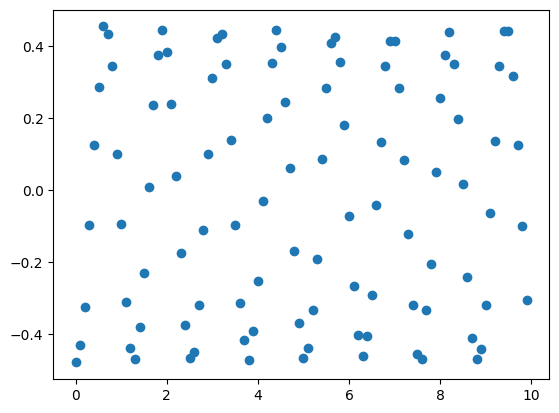

In [42]:
print(process_two_state(run42CycleResults, "000"))
plt.scatter(run3Range, process_two_state(run42CycleResults, "000"))
plt.show()

[553, 545, 541, 508, 508, 550, 521, 541, 550, 526, 553, 526, 526, 535, 554, 525, 508, 549, 521, 535, 537, 517, 571, 533, 537, 534, 555, 536, 564, 539, 546, 550, 558, 535, 527, 510, 535, 510, 506, 528, 560, 502, 527, 535, 532, 544, 548, 560, 529, 546, 542, 555, 520, 557, 549, 533, 543, 507, 535, 530, 546, 536, 560, 516, 510, 538, 551, 541, 525, 526, 564, 550, 557, 538, 522, 535, 554, 535, 547, 522, 541, 568, 516, 561, 542, 538, 550, 557, 568, 531, 515, 530, 538, 525, 539, 537, 545, 519, 535, 525]
[-0.4529837251356239, -0.41559633027522935, -0.27264325323475047, -0.017716535433070835, 0.17716535433070868, 0.3218181818181818, 0.41938579654510555, 0.422365988909427, 0.26727272727272733, 0.09695817490494296, -0.14918625678119346, -0.31558935361216733, -0.4505703422053232, -0.4495327102803738, -0.3592057761732852, -0.17047619047619045, 0.025590551181102345, 0.25045537340619306, 0.3963531669865643, 0.4214953271028037, 0.36592178770949724, 0.19632495164410058, 0.004378283712784592, -0.25046904

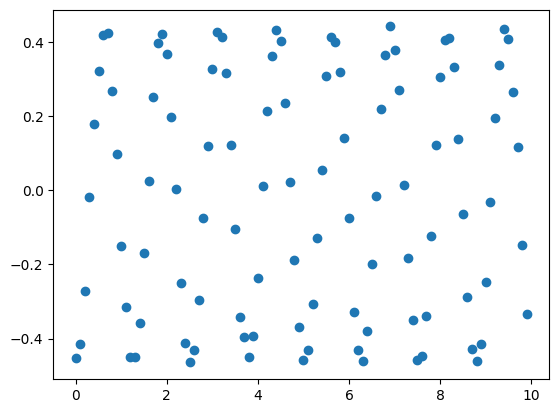

In [66]:
print(process_two_state(run43CycleResults, "0000"))
plt.scatter(run3Range, process_two_state(run43CycleResults, "0000"))
plt.show()

[410, 415, 404, 398, 394, 394, 416, 404, 387, 374, 389, 386, 414, 401, 387, 388, 408, 401, 402, 404, 388, 405, 360, 412, 377, 434, 394, 379, 348, 385, 367, 393, 410, 393, 346, 398, 399, 379, 389, 357, 391, 349, 399, 409, 378, 360, 370, 393, 389, 374, 398, 392, 382, 396, 394, 408, 371, 387, 417, 402, 384, 390, 420, 384, 406, 396, 404, 394, 415, 395, 426, 390, 415, 409, 355, 417, 397, 407, 389, 418, 389, 388, 409, 398, 388, 404, 399, 388, 426, 400, 387, 391, 425, 426, 407, 387, 376, 380, 403, 375]
[-0.4463414634146341, -0.4036144578313253, -0.2698019801980198, -0.042713567839196, 0.14467005076142134, 0.35279187817258884, 0.4326923076923077, 0.4331683168316831, 0.28552971576227393, 0.12834224598930485, -0.12724935732647813, -0.3341968911917098, -0.4371980676328503, -0.4625935162094763, -0.3630490956072352, -0.20876288659793818, -0.004901960784313708, 0.24812967581047382, 0.37810945273631846, 0.43811881188118806, 0.3608247422680413, 0.1987654320987654, 0.04722222222222225, -0.2233009708737

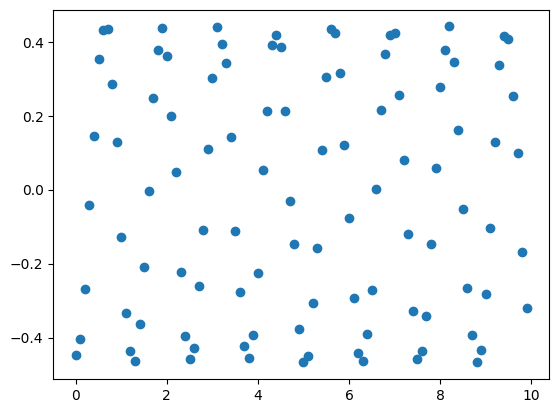

In [65]:
print(process_two_state(run44CycleResults, "00000"))
plt.scatter(run3Range, process_two_state(run44CycleResults, "00000"))
plt.show()

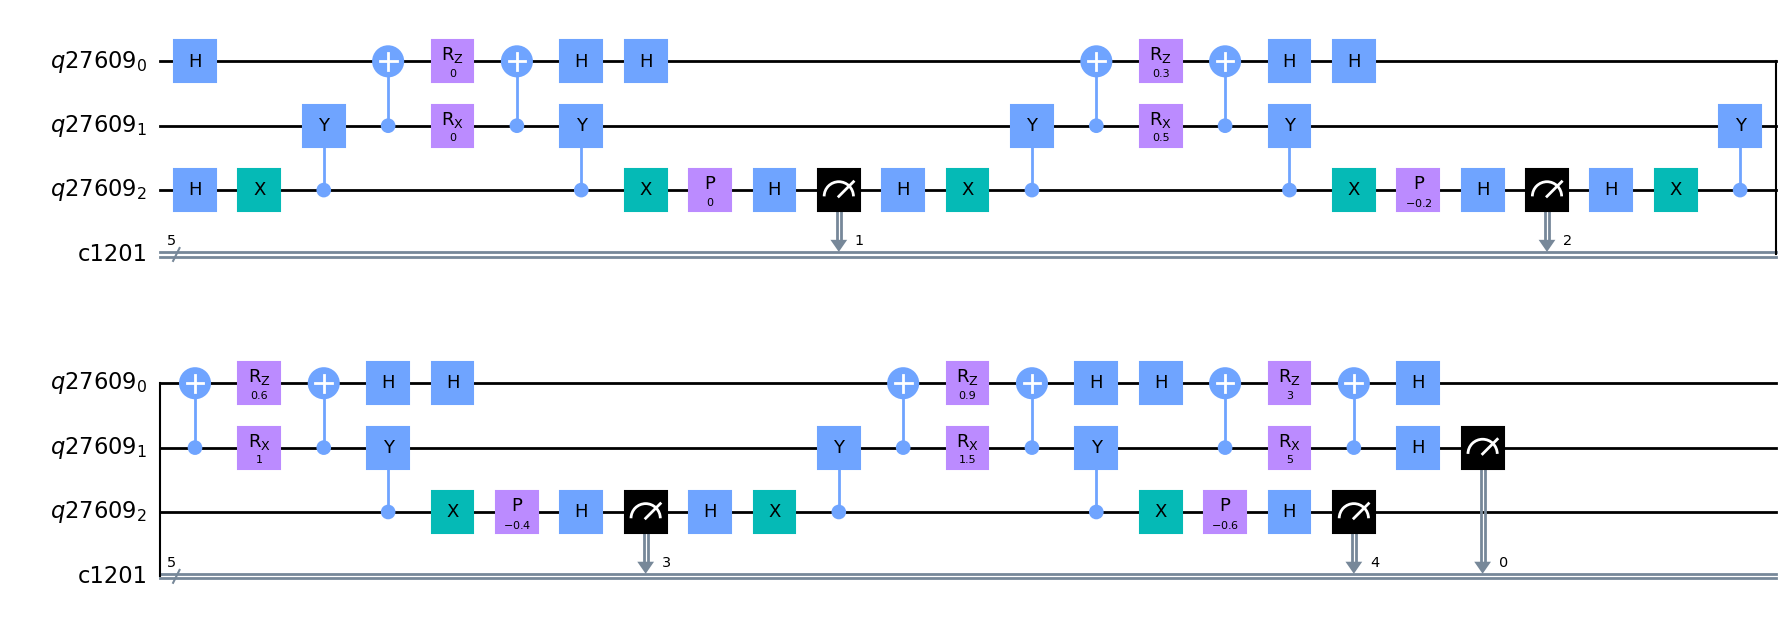

In [47]:
circ = run_rodeo(run1Range, 4, -1, 2.5, 1.5, 1, True)
circ.draw('mpl')

In [50]:
run5Job1Cycle = run_two_state(1, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job1Cycle.job_set_id())
run51CycleResults = run5Job1Cycle.results()

run5Job2Cycle = run_two_state(2, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job2Cycle.job_set_id())
run52CycleResults = run5Job2Cycle.results()

run5Job3Cycle = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job3Cycle.job_set_id())
run53CycleResults = run5Job3Cycle.results()

run5Job4Cycle = run_two_state(4, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job4Cycle.job_set_id())
run54CycleResults = run5Job4Cycle.results()

6eebabcf8686434984bec5f4fdefaefb-16362992230827897
065efc482ce64d96b6cdddb1ee1bf01b-16362992711233456
f9631d5b3172421e951eded7f1badca1-16362993287257757
649fdb61b0994502870d872a6ce321ec-16362993882994504


[0.005119453924914669, 0.03251318101933218, -0.03608247422680411, -0.01488616462346759, -0.017123287671232834, -0.002546689303904892, 0.002617801047120394, 0.0017605633802817156, -0.03344768439108059, -0.04878048780487809, -0.03658536585365857, -0.026936026936026924, -0.03637901861252113, -0.02447552447552448, -0.01832460732984298, 0.009031198686371117, 0.0, -0.028911564625850317, -0.027545909849749584, -0.028239202657807327, 0.014529914529914506, 0.03088480801335558, 0.01960784313725486, 0.06122448979591841, 0.038732394366197215, 0.04166666666666671, -0.03678929765886285, -0.037288135593220306, -0.010526315789473717, -0.00545454545454549, -0.03542009884678743, -0.027491408934707917, -0.04483925549915402, -0.058260869565217366, -0.042314335060449015, -0.0383275261324042, -0.011627906976744207, -0.004273504273504258, -0.04895104895104896, -0.012520868113522488, -0.006734006734006703, 0.032094594594594544, -0.02533783783783783, -0.0050167224080267525, -0.005785123966942196, -0.0017857142

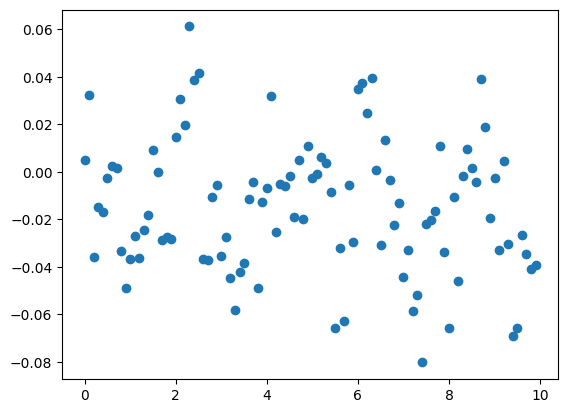

In [51]:
print(process_two_state(run51CycleResults, "00"))
plt.scatter(run3Range, process_two_state(run51CycleResults, "00"))
plt.show()

[0.05353535353535355, 0.007968127490039834, -0.014970059880239472, -0.030487804878048808, -0.022821576763485507, -0.038461538461538436, -0.06262833675564683, -0.12815126050420167, -0.10358565737051795, -0.1015625, -0.04697286012526092, -0.047945205479452024, -0.01807228915662651, -0.012096774193548376, 0.027542372881355942, -0.01650485436893201, 0.03526970954356845, 0.030571992110453666, 0.03725490196078429, 0.04811715481171544, 0.020467836257309968, 0.06972111553784857, 0.015686274509803894, 0.038775510204081653, -0.036821705426356544, -0.007128309572301372, -0.048387096774193505, -0.07113821138211385, -0.09748427672955973, -0.07287449392712553, -0.10912698412698407, -0.0805084745762712, -0.05214723926380371, -0.10236220472440949, -0.030271398747390377, -0.004166666666666652, 0.05397148676171082, 0.05060728744939269, 0.009960159362549792, 0.0353319057815846, 0.030655391120507414, 0.0426829268292683, 0.044910179640718556, 0.01491053677932408, 0.0019379844961240345, -0.05093555093555091

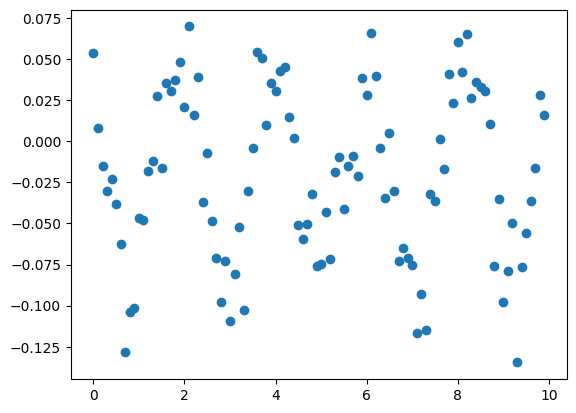

In [52]:
print(process_two_state(run52CycleResults, "000"))
plt.scatter(run3Range, process_two_state(run52CycleResults, "000"))
plt.show()

[-0.0611510791366906, -0.11554192229038851, -0.06762295081967218, -0.046534653465346576, -0.01984877126654061, -0.014227642276422814, 0.03280318091451287, 0.027450980392156876, 0.06673511293634496, 0.05601659751037347, 0.06470588235294117, 0.0506958250497018, 0.04705882352941179, -0.017525773195876337, -0.04417670682730923, -0.005725190839694694, -0.03620352250489234, -0.08522727272727271, -0.05769230769230771, -0.07058823529411762, -0.12523900573613767, -0.0741811175337187, -0.06995884773662553, -0.05900621118012417, -0.033742331288343586, -0.03200000000000003, -0.0031185031185031464, 0.014506769825918725, 0.08895705521472388, 0.07028112449799195, 0.02577319587628868, 0.013238289205702608, -0.019607843137254943, 0.05711422845691383, 0.014099783080260303, -0.007968127490039834, -0.02164948453608251, -0.017034068136272507, -0.06799999999999995, -0.0677799607072691, -0.08283433133732532, -0.06716417910447758, -0.05193482688391038, -0.09631147540983609, -0.044061302681992376, -0.058704453

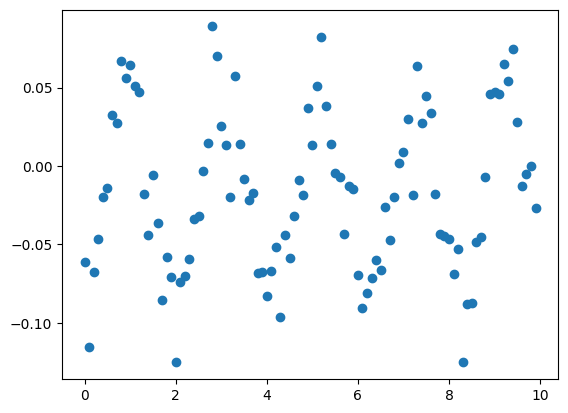

In [53]:
print(process_two_state(run53CycleResults, "0000"))
plt.scatter(run3Range, process_two_state(run53CycleResults, "0000"))
plt.show()

[402, 410, 366, 392, 394, 395, 403, 382, 390, 403, 410, 408, 394, 406, 372, 383, 397, 387, 398, 390, 396, 407, 396, 411, 440, 396, 357, 387, 370, 413, 412, 388, 395, 395, 375, 404, 385, 403, 398, 382, 404, 394, 391, 419, 389, 388, 387, 391, 399, 396, 423, 391, 396, 402, 412, 405, 411, 399, 403, 400, 402, 405, 404, 399, 396, 419, 408, 407, 384, 403, 401, 382, 395, 375, 384, 384, 385, 415, 409, 370, 402, 381, 405, 383, 391, 382, 357, 390, 373, 382, 387, 402, 372, 394, 394, 393, 423, 382, 412, 403]
[0.04726368159203978, 0.03170731707317073, 0.010928961748633892, 0.020408163265306145, -0.0025380710659898, -0.01898734177215189, -0.06079404466501237, -0.03926701570680624, -0.02051282051282055, -0.053349875930521096, -0.060975609756097615, -0.0759803921568627, -0.06598984771573602, -0.007389162561576401, -0.07526881720430112, 0.011749347258485643, -0.041561712846347576, 0.003875968992248069, 0.02010050251256279, 0.023076923076923023, -0.002525252525252486, -0.023341523341523396, 0.00252525252

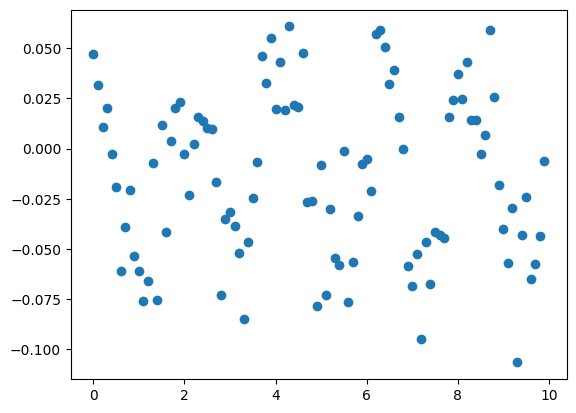

In [64]:
print(process_two_state(run54CycleResults, "00000"))
plt.scatter(run3Range, process_two_state(run54CycleResults, "00000"))
plt.show()

In [56]:
run6Job0Cycle = run_two_state(0, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run6Job0Cycle.job_set_id())
run60CycleResults = run6Job0Cycle.results()

9bf1de8f3e5847b0a50bea540ecffcaf-16362997508717487


[-0.0400390625, -0.0146484375, -0.0205078125, -0.0048828125, -0.0263671875, -0.046875, -0.044921875, -0.0595703125, -0.0048828125, -0.013671875, -0.0361328125, -0.001953125, -0.001953125, -0.01171875, 0.01171875, -0.005859375, -0.0068359375, 0.00390625, -0.02734375, -0.0087890625, -0.0234375, 0.0166015625, 0.0087890625, 0.005859375, 0.00390625, -0.0078125, -0.0068359375, -0.017578125, -0.0244140625, 0.0009765625, -0.013671875, -0.0517578125, -0.0224609375, -0.03125, -0.05078125, -0.01171875, -0.0166015625, -0.01953125, -0.0009765625, -0.037109375, -0.0390625, 0.001953125, -0.0234375, -0.0263671875, -0.0224609375, -0.0234375, -0.0205078125, -0.009765625, 0.00390625, -0.015625, -0.00390625, 0.0048828125, 0.017578125, 0.0068359375, 0.0302734375, -0.017578125, -0.05859375, -0.017578125, -0.005859375, 0.00390625, -0.0341796875, 0.009765625, -0.001953125, -0.005859375, -0.03515625, -0.0126953125, -0.0419921875, -0.048828125, -0.0029296875, -0.0166015625, -0.0439453125, -0.0478515625, -0.0390

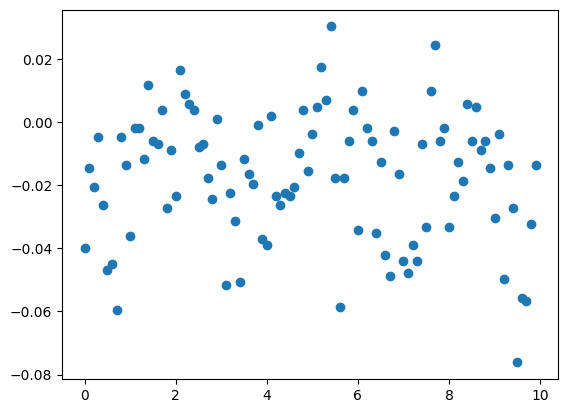

In [58]:
print(process_two_state(run60CycleResults, "0"))
plt.scatter(run3Range, process_two_state(run60CycleResults, "0"))
plt.show()

In [60]:
run7Job0Cycle = run_two_state(0, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False)
print(run7Job0Cycle.job_set_id())
run70CycleResults = run7Job0Cycle.results()

df9cfcdb300a4a8091d59bba493df85e-16363002101311603


[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
[-0.490234375, -0.4306640625, -0.279296875, -0.0810546875, 0.1630859375, 0.3681640625, 0.4501953125, 0.4267578125, 0.2783203125, 0.0927734375, -0.166015625, -0.353515625, -0.4736328125, -0.46875, -0.3701171875, -0.1318359375, 0.0341796875, 0.244140625, 0.416015625, 0.46484375, 0.392578125, 0.1982421875, 0.0107421875, -0.232421875, -0.408203125, -0.4931640625, -0.443359375, -0.302734375, -0.0625, 

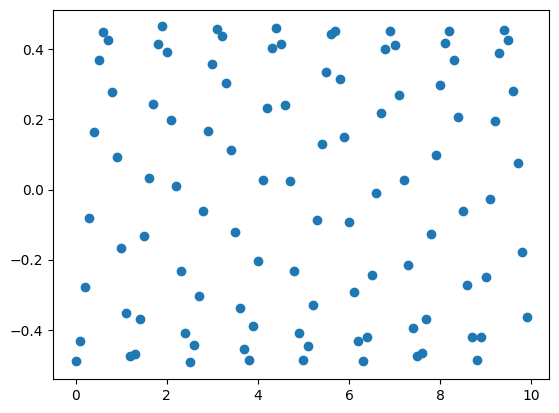

In [63]:
print(process_two_state(run70CycleResults, "0"))
plt.scatter(run3Range, process_two_state(run70CycleResults, "0"))
plt.show()

In [67]:
run8Job1Cycle = run_two_state(1, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job1Cycle.job_set_id())
run81CycleResults = run8Job1Cycle.results()

run8Job2Cycle = run_two_state(2, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job2Cycle.job_set_id())
run82CycleResults = run8Job2Cycle.results()

run8Job3Cycle = run_two_state(3, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job3Cycle.job_set_id())
run83CycleResults = run8Job3Cycle.results()

run8Job4Cycle = run_two_state(4, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job4Cycle.job_set_id())
run84CycleResults = run8Job4Cycle.results()

ab197678dab44fe0b9c8da1a7168d3ec-1636301096413536
313800d9d95d41379a3cacc7e727f980-16363013051810856
68f092d040de4053bfc10018533738fe-16363015443579872
88f34879305048b1a7169acb80131183-1636301739849467


[652, 672, 662, 648, 659, 640, 693, 644, 642, 674, 653, 657, 655, 659, 646, 666, 651, 628, 643, 653, 677, 663, 669, 662, 671, 673, 664, 682, 665, 672, 657, 656, 686, 643, 654, 658, 669, 666, 646, 674, 677, 643, 642, 660, 657, 640, 657, 647, 658, 665, 681, 673, 643, 666, 658, 647, 669, 667, 642, 652, 656, 670, 664, 679, 644, 669, 650, 668, 669, 629, 638, 673, 651, 669, 648, 652, 655, 669, 638, 650, 664, 665, 652, 645, 661, 668, 638, 682, 655, 670, 638, 682, 661, 627, 623, 669, 622, 666, 659, 649]
[-0.32515337423312884, -0.28869047619047616, -0.24773413897280971, -0.17901234567901236, -0.11001517450682852, -0.03281250000000002, 0.039682539682539736, 0.12267080745341616, 0.16043613707165114, 0.2537091988130564, 0.2718223583460949, 0.28234398782343995, 0.22366412213740453, 0.19802731411229135, 0.14241486068111453, 0.08858858858858862, -0.025345622119815614, -0.05095541401273884, -0.19673405909797825, -0.20903522205206737, -0.2991137370753324, -0.2737556561085973, -0.26681614349775784, -0.2

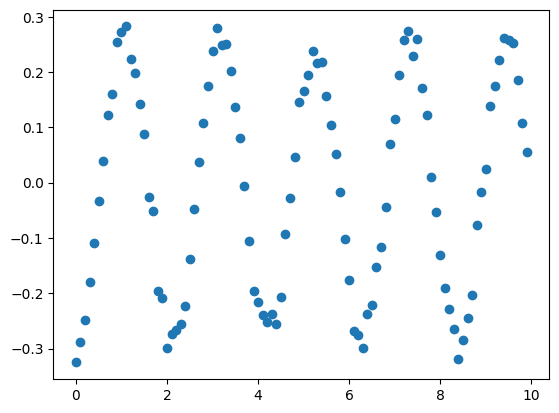

In [68]:
print(process_two_state(run81CycleResults, "00"))
plt.scatter(run3Range, process_two_state(run81CycleResults, "00"))
plt.show()

[387, 381, 373, 391, 403, 366, 366, 397, 350, 377, 411, 372, 398, 371, 366, 367, 336, 405, 367, 363, 355, 360, 384, 365, 374, 371, 369, 383, 367, 353, 388, 376, 380, 366, 366, 362, 392, 380, 384, 364, 368, 372, 374, 350, 361, 342, 400, 356, 384, 377, 371, 368, 369, 378, 373, 348, 408, 377, 399, 390, 353, 378, 377, 358, 361, 382, 373, 382, 382, 382, 386, 364, 360, 373, 358, 373, 375, 395, 364, 375, 361, 352, 365, 349, 374, 352, 390, 391, 382, 379, 405, 395, 384, 360, 371, 376, 408, 376, 362, 399]
[0.07881136950904397, 0.03280839895013121, -0.06836461126005366, -0.02941176470588236, -0.1253101736972705, -0.08743169398907102, -0.12295081967213117, -0.13476070528967254, -0.14857142857142858, -0.1816976127320955, -0.0888077858880778, -0.09139784946236562, -0.002512562814070307, -0.01752021563342321, 0.08469945355191255, 0.08583106267029972, 0.09226190476190477, 0.08518518518518522, 0.11580381471389645, 0.14462809917355376, 0.1507042253521127, 0.07222222222222222, 0.05989583333333329, 0.0013

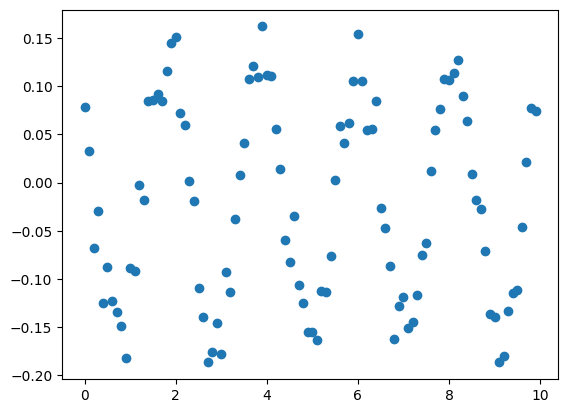

In [69]:
print(process_two_state(run82CycleResults, "000"))
plt.scatter(run3Range, process_two_state(run82CycleResults, "000"))
plt.show()

[286, 274, 277, 274, 283, 295, 263, 293, 308, 293, 272, 279, 304, 280, 258, 291, 280, 284, 285, 287, 294, 279, 268, 278, 251, 279, 313, 282, 295, 305, 272, 274, 285, 302, 286, 327, 281, 279, 296, 294, 302, 265, 277, 302, 301, 341, 288, 265, 257, 277, 284, 292, 246, 310, 271, 310, 287, 296, 295, 301, 273, 304, 295, 281, 289, 281, 292, 302, 292, 278, 313, 289, 309, 286, 315, 293, 280, 285, 294, 260, 286, 286, 297, 290, 271, 306, 270, 278, 286, 299, 284, 294, 253, 314, 302, 296, 292, 309, 295, 260]
[0.16083916083916083, 0.19343065693430653, 0.10649819494584836, 0.0948905109489051, -0.026501766784452263, -0.07288135593220335, -0.13498098859315588, -0.20989761092150172, -0.2727272727272727, -0.26791808873720135, -0.21691176470588236, -0.2060931899641577, -0.14802631578947367, -0.11428571428571432, -0.03100775193798455, 0.015463917525773169, 0.11071428571428574, 0.13028169014084504, 0.17368421052631577, 0.2073170731707317, 0.20068027210884354, 0.20967741935483872, 0.18283582089552233, 0.1043

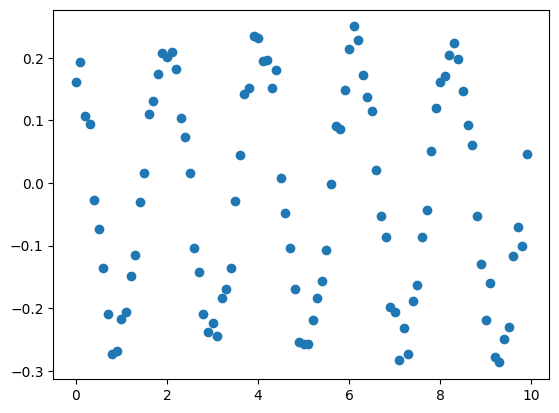

In [70]:
print(process_two_state(run83CycleResults, "0000"))
plt.scatter(run3Range, process_two_state(run83CycleResults, "0000"))
plt.show()

[286, 285, 278, 294, 273, 314, 308, 295, 277, 279, 282, 307, 309, 317, 313, 296, 303, 281, 312, 287, 267, 297, 289, 262, 295, 273, 273, 303, 293, 303, 305, 283, 291, 270, 313, 284, 311, 275, 278, 289, 287, 290, 285, 289, 270, 317, 313, 303, 273, 289, 283, 287, 298, 274, 290, 308, 305, 270, 295, 267, 321, 274, 277, 278, 291, 281, 280, 315, 281, 277, 297, 296, 307, 294, 299, 324, 324, 282, 285, 309, 284, 284, 290, 289, 297, 264, 277, 288, 286, 297, 289, 294, 285, 296, 298, 285, 283, 298, 266, 281]
[0.006993006993006978, 0.015789473684210548, 0.07194244604316546, 0.09183673469387754, 0.07142857142857142, 0.08917197452229297, 0.09415584415584413, 0.05254237288135591, -0.016245487364620947, 0.0017921146953405465, 0.007092198581560294, -0.021172638436482094, -0.1181229773462783, -0.08359621451104104, -0.07507987220447288, -0.10810810810810811, -0.05775577557755773, 0.008896797153024938, -0.022435897435897467, -0.06794425087108014, -0.028089887640449396, 0.06902356902356901, 0.043252595155709

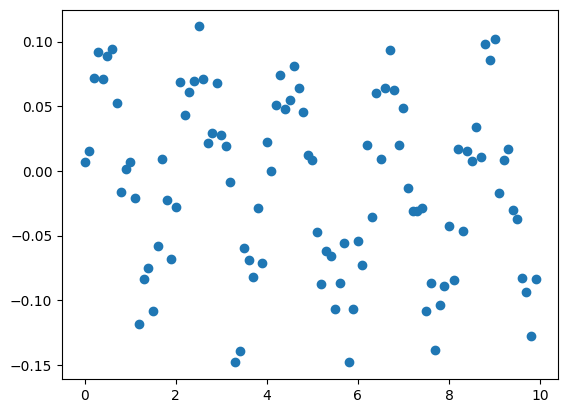

In [71]:
print(process_two_state(run84CycleResults, "00000"))
plt.scatter(run3Range, process_two_state(run84CycleResults, "00000"))
plt.show()

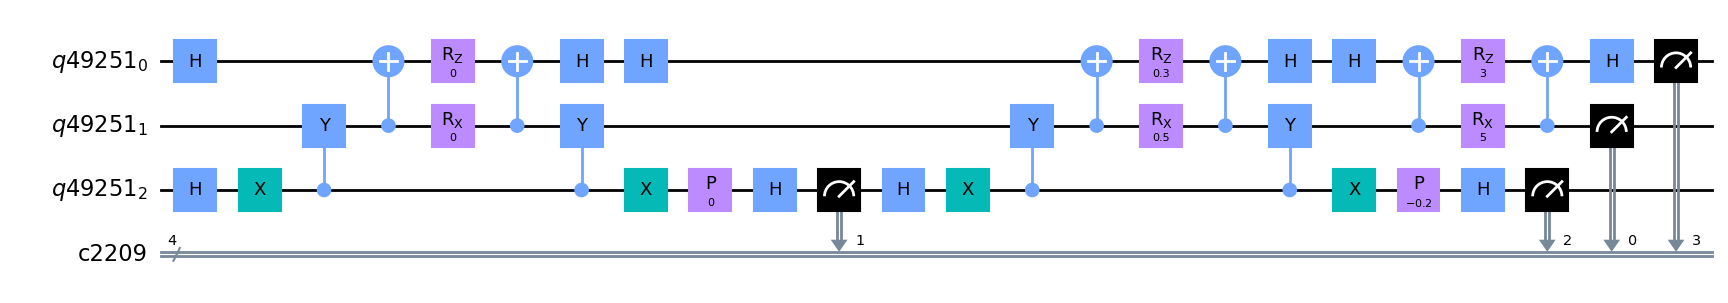

In [80]:
circ = run_rodeo(run1Range, 2, -1, 2.5, 1.5, 1, False, True)
circ.draw('mpl')

In [82]:
run9Job = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run9Job.job_set_id())
run9Results = run9Job.results()

cd7f8c76063642b7825e524d3abcaf21-16363457514317062


[640, 611, 608, 590, 586, 598, 612, 605, 588, 602, 605, 635, 599, 618, 590, 594, 583, 627, 588, 619, 606, 627, 576, 600, 619, 626, 609, 616, 636, 612, 614, 616, 629, 607, 631, 618, 599, 629, 632, 625, 605, 599, 604, 591, 582, 553, 583, 626, 599, 591, 609, 602, 610, 609, 608, 612, 586, 605, 619, 596, 595, 614, 633, 607, 616, 609, 599, 598, 598, 606, 616, 631, 589, 593, 586, 627, 608, 611, 631, 609, 617, 604, 626, 597, 623, 609, 591, 604, 612, 628, 619, 607, 605, 594, 613, 576, 620, 607, 601, 629]
[-0.5109374999999999, -0.46153846153846156, -0.2993421052631579, -0.07288135593220335, 0.18259385665529007, 0.37625418060200666, 0.4852941176470589, 0.4413223140495868, 0.3282312925170068, 0.207641196013289, -0.047933884297520546, -0.3181102362204724, -0.38397328881469106, -0.4692556634304207, -0.34915254237288135, -0.22558922558922556, -0.005145797598627766, 0.17703349282296643, 0.30102040816326525, 0.3570274636510501, 0.34818481848184824, 0.164274322169059, -0.05034722222222221, -0.1849999999

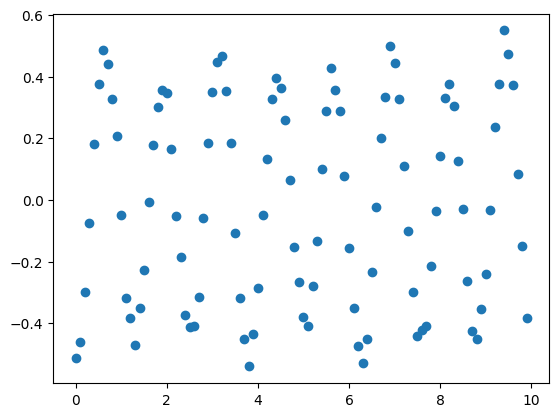

In [83]:
print(process_two_state_dual(run9Results, "00000"))
plt.scatter(run1Range, process_two_state_dual(run9Results, "00000"))
plt.show()

In [32]:
run9Job2 = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run9Job2.job_set_id())
run9Results2 = run9Job2.results()

2b92619e0f7c4cfaa574806f45fb48dd-16376710896343613


[445, 424, 445, 432, 466, 430, 439, 440, 448, 457, 448, 430, 435, 460, 439, 427, 467, 436, 452, 431, 458, 431, 424, 417, 440, 434, 432, 432, 415, 451, 433, 420, 436, 428, 437, 451, 443, 423, 414, 423, 456, 420, 446, 453, 418, 449, 439, 424, 412, 425, 434, 456, 443, 438, 481, 447, 435, 423, 413, 399, 423, 448, 467, 434, 431, 465, 456, 454, 440, 427, 470, 411, 445, 444, 440, 484, 440, 436, 444, 431, 452, 445, 452, 452, 432, 443, 415, 434, 458, 467, 453, 445, 471, 434, 434, 438, 430, 473, 435, 452]
[-0.4876404494382022, -0.5306603773584906, -0.3303370786516853, -0.12037037037037035, 0.1201716738197425, 0.32558139534883734, 0.48747152619589973, 0.4772727272727273, 0.3705357142857143, 0.19256017505470457, -0.024553571428571508, -0.17906976744186043, -0.3655172413793103, -0.417391304347826, -0.3644646924829158, -0.20843091334894615, -0.0770877944325482, 0.15825688073394495, 0.2588495575221238, 0.30626450116009285, 0.29694323144104795, 0.18561484918793503, -0.04952830188679247, -0.30215827338

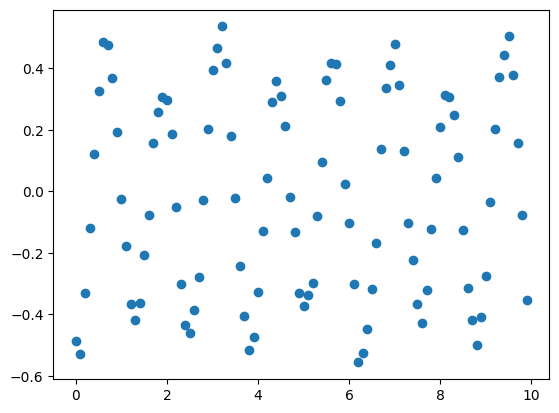

In [33]:
print(process_two_state_dual(run9Results2, "00000"))
plt.scatter(run1Range, process_two_state_dual(run9Results2, "00000"))
plt.show()

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: 31b41e1412514a22bb2bd1c4c43fa237-16363468422700083
second pass w/ peaks:
[-4.0, -1.0, 0.0, 1.0, 3.0, 4.0]
first run job id: 8e8a8f99e91341b09c2312eb6298b6c1-16363471783677413
done w/ second pass


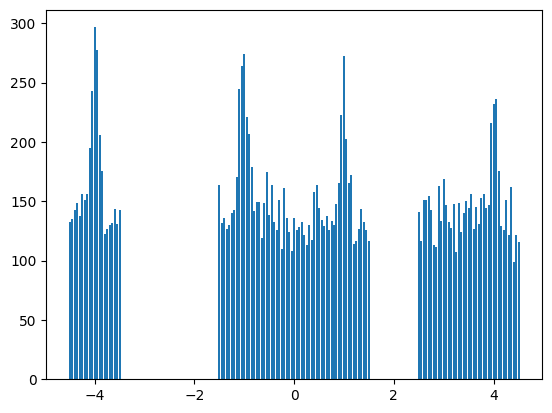

In [86]:
allOverlapSpec = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5, backend=backendJakarta), 1)
plot_scans(allOverlapSpec)

In [87]:
print(allOverlapSpec)

[[[-4.5, 132.84], [-4.45, 135.12], [-4.4, 142.92], [-4.35, 148.2], [-4.3, 137.8], [-4.25, 155.88], [-4.2, 151.08], [-4.15, 156.24], [-4.1, 195.0], [-4.05, 243.0], [-4.0, 296.64], [-3.95, 277.48], [-3.9, 206.12], [-3.85, 175.52], [-3.8, 122.28], [-3.75, 126.32], [-3.7, 129.8], [-3.65, 132.12], [-3.6, 143.48], [-3.55, 131.0], [-3.5, 142.84]], [[-1.5, 163.6], [-1.4500000000000002, 131.72], [-1.4, 135.96], [-1.35, 126.44], [-1.3, 129.68], [-1.25, 140.32], [-1.2000000000000002, 143.0], [-1.15, 170.84], [-1.1, 244.24], [-1.05, 264.32], [-1.0, 274.32], [-0.95, 221.36], [-0.9, 206.56], [-0.8500000000000001, 179.0], [-0.8, 141.4], [-0.75, 149.32], [-0.7, 149.24], [-0.65, 118.88], [-0.6, 148.4], [-0.55, 174.92], [-0.5, 138.72]], [[-0.5, 129.12], [-0.45000000000000007, 163.72], [-0.4, 132.36], [-0.3500000000000001, 125.76], [-0.30000000000000004, 151.4], [-0.25, 109.52], [-0.20000000000000007, 161.6], [-0.15000000000000002, 136.32], [-0.10000000000000009, 123.84], [-0.050000000000000044, 108.2], 

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: c88acbca74134a7e9655fd3c85d8e7c4-16363487498615456
second pass w/ peaks:
[-5.0, -4.0, -2.0, -1.0, 0.0, 1.0, 4.0, 5.0]
first run job id: 810ec2f0fbc04ea6988ad86c53b538e2-1636349046568691
done w/ second pass


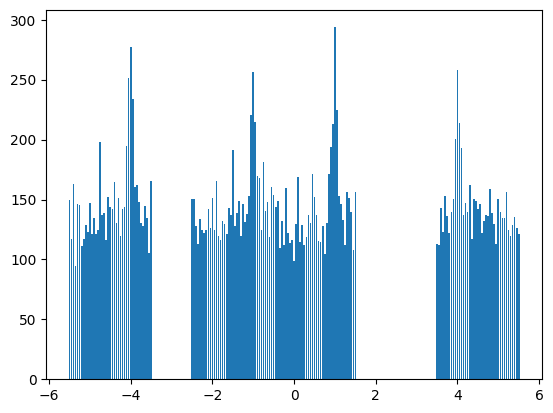

[[[-5.5, 149.36], [-5.45, 117.2], [-5.4, 162.64], [-5.35, 94.72], [-5.3, 146.2], [-5.25, 145.2], [-5.2, 111.6], [-5.15, 117.32], [-5.1, 128.76], [-5.05, 122.72], [-5.0, 147.32], [-4.95, 120.84], [-4.9, 134.32], [-4.85, 121.44], [-4.8, 124.96], [-4.75, 198.32], [-4.7, 136.84], [-4.65, 139.12], [-4.6, 116.56], [-4.55, 152.44], [-4.5, 122.88]], [[-4.5, 143.76], [-4.45, 142.4], [-4.4, 164.48], [-4.35, 130.2], [-4.3, 150.88], [-4.25, 119.68], [-4.2, 142.24], [-4.15, 144.04], [-4.1, 194.36], [-4.05, 251.4], [-4.0, 277.4], [-3.95, 234.16], [-3.9, 160.52], [-3.85, 162.4], [-3.8, 148.04], [-3.75, 130.44], [-3.7, 128.04], [-3.65, 144.88], [-3.6, 134.56], [-3.55, 105.44], [-3.5, 165.16]], [[-2.5, 150.12], [-2.45, 150.2], [-2.4, 128.16], [-2.35, 112.76], [-2.3, 133.8], [-2.25, 124.52], [-2.2, 121.92], [-2.15, 124.76], [-2.1, 141.68], [-2.05, 125.84], [-2.0, 151.16], [-1.95, 124.92], [-1.9, 165.48], [-1.85, 119.36], [-1.8, 116.44], [-1.75, 131.84], [-1.7, 129.76], [-1.65, 121.08], [-1.6, 142.88], [

In [88]:
allOverlapSpec2 = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5, backend=backendJakarta), 1)
plot_scans(allOverlapSpec2)
print(allOverlapSpec2)

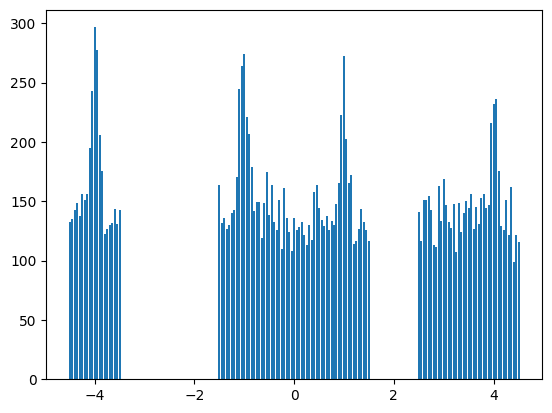

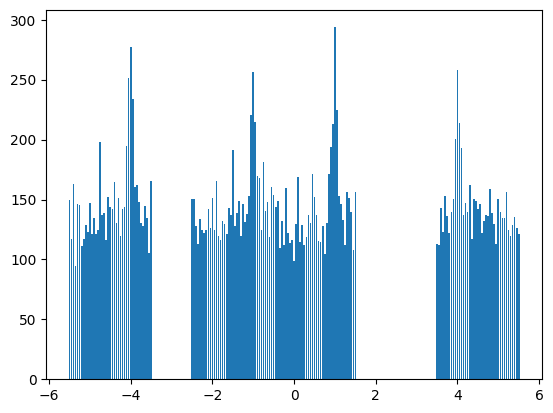

In [89]:
plot_scans(allOverlapSpec)
plot_scans(allOverlapSpec2)

In [90]:
run10Job0 = run_two_state(0, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job0.job_set_id())
run10Results0 = run10Job0.results()

run10Job1 = run_two_state(1, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job1.job_set_id())
run10Results1 = run10Job1.results()

run10Job2 = run_two_state(2, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job2.job_set_id())
run10Results2 = run10Job2.results()

run10Job3 = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job3.job_set_id())
run10Results3 = run10Job3.results()

run10Job4 = run_two_state(4, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job4.job_set_id())
run10Results4 = run10Job4.results()

run10Job5 = run_two_state(5, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job5.job_set_id())
run10Results5 = run10Job5.results()

print("done with all")

4d34aca733c143679372033076bbc461-16363775384703617
14a69ab302b44fa1a2fd369444fb3023-1636377671323529
9041c8fbcecc4f4dbf70c93aa32d4b43-16363778924858296
51d18d3b0f71434aaa1ebd03fcd8239b-16363780891270692
b64dcce65b184b7fa1262875209ad9de-16363782918624887
b9f45b9d0953462195ddb86f76b4d9af-16363784040733578
done with all


[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
[-0.9501953125, -0.8876953125, -0.681640625, -0.4111328125, -0.0625, 0.26171875, 0.501953125, 0.5771484375, 0.529296875, 0.4033203125, 0.2451171875, 0.0361328125, -0.1171875, -0.1669921875, -0.169921875, -0.123046875, -0.0166015625, 0.0244140625, 0.05859375, 0.01171875, -0.1162109375, -0.3115234375, -0.4609375, -0.630859375, -0.7216796875, -0.662109375, -0.5390625, -0.267578125, 0.150390625, 0.42

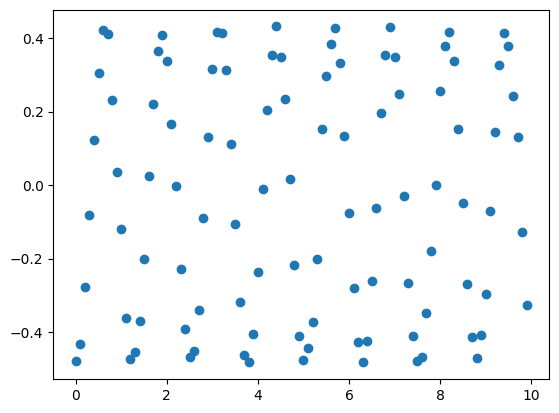

In [92]:
print(process_two_state_dual(run10Results0, "00"))
plt.scatter(run1Range, process_two_state(run10Results0, "00"))
plt.show()

[855, 857, 844, 855, 846, 870, 868, 860, 859, 875, 856, 872, 848, 856, 882, 876, 841, 869, 854, 859, 864, 834, 850, 864, 871, 852, 849, 855, 864, 842, 839, 871, 893, 873, 863, 866, 848, 852, 873, 848, 860, 869, 866, 870, 898, 865, 857, 866, 861, 850, 865, 861, 865, 868, 856, 818, 870, 856, 843, 854, 868, 881, 859, 879, 850, 845, 866, 872, 857, 841, 863, 858, 851, 865, 844, 860, 866, 854, 870, 863, 864, 868, 849, 851, 873, 849, 859, 849, 851, 834, 847, 874, 855, 851, 847, 855, 869, 855, 860, 853]
[-0.10643274853801166, -0.037339556592765444, 0.08530805687203802, 0.20701754385964913, 0.2836879432624114, 0.3275862068965517, 0.2569124423963134, 0.13372093023255816, -0.14435389988358557, -0.3931428571428571, -0.6565420560747663, -0.8165137614678899, -0.8761792452830189, -0.8014018691588785, -0.5419501133786848, -0.23972602739726023, 0.13793103448275865, 0.4131185270425777, 0.6241217798594847, 0.7217694994179278, 0.6435185185185185, 0.460431654676259, 0.23764705882352943, -0.0243055555555555

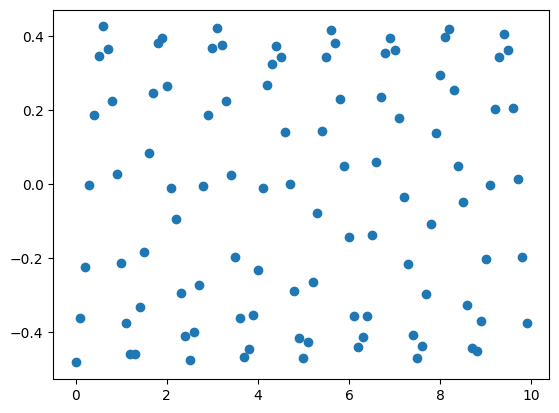

In [91]:
print(process_two_state_dual(run10Results1, "000"))
plt.scatter(run1Range, process_two_state(run10Results1, "000"))
plt.show()

[579, 581, 559, 523, 552, 553, 555, 582, 597, 554, 562, 559, 593, 553, 549, 570, 560, 566, 539, 530, 555, 550, 579, 570, 555, 597, 551, 540, 584, 564, 566, 592, 547, 547, 557, 546, 560, 569, 554, 558, 567, 565, 580, 561, 557, 535, 569, 562, 562, 550, 568, 569, 558, 552, 552, 550, 534, 548, 559, 546, 547, 581, 575, 519, 534, 520, 563, 546, 556, 574, 570, 588, 534, 558, 582, 528, 558, 530, 560, 565, 577, 544, 552, 559, 522, 566, 539, 543, 527, 576, 562, 545, 561, 564, 564, 562, 575, 574, 554, 543]
[-0.3367875647668394, -0.2512908777969018, -0.16994633273703041, 0.030592734225621476, 0.10144927536231885, 0.3309222423146474, 0.28828828828828834, 0.23024054982817876, 0.06030150753768837, -0.14259927797833938, -0.32562277580071175, -0.5456171735241503, -0.5699831365935919, -0.6292947558770343, -0.4954462659380693, -0.3070175438596492, -0.0357142857142857, 0.21378091872791516, 0.4452690166975881, 0.539622641509434, 0.4396396396396396, 0.3563636363636364, 0.17616580310880828, -0.09824561403508

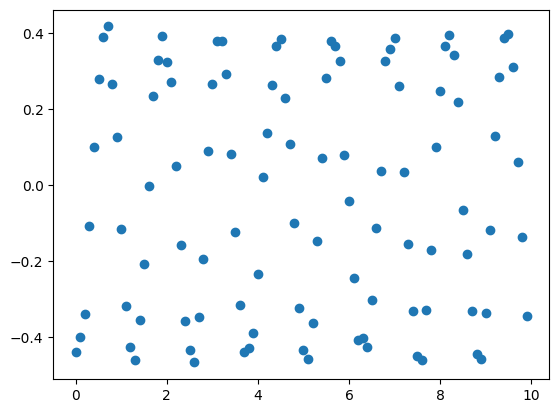

In [93]:
print(process_two_state_dual(run10Results2, "0000"))
plt.scatter(run1Range, process_two_state(run10Results2, "0000"))
plt.show()

[659, 605, 629, 630, 639, 648, 595, 629, 644, 653, 628, 641, 641, 623, 640, 638, 627, 610, 630, 643, 638, 615, 644, 634, 642, 615, 625, 649, 650, 656, 618, 634, 636, 619, 635, 618, 598, 600, 643, 647, 601, 627, 640, 664, 613, 627, 651, 648, 630, 629, 628, 634, 612, 643, 651, 637, 631, 650, 632, 640, 620, 634, 649, 600, 621, 646, 648, 634, 642, 644, 614, 658, 629, 631, 630, 650, 639, 638, 589, 610, 622, 626, 638, 645, 627, 633, 620, 623, 629, 631, 625, 642, 614, 650, 609, 640, 630, 639, 615, 612]
[-0.7223065250379364, -0.7388429752066116, -0.5659777424483308, -0.3396825396825396, -0.1408450704225352, 0.18055555555555558, 0.3445378151260504, 0.3926868044515104, 0.3555900621118012, 0.2679938744257274, 0.019108280254777066, -0.03744149765990645, -0.17472698907956324, -0.24558587479935784, -0.221875, -0.11442006269592475, 0.07177033492822962, 0.13770491803278684, 0.14761904761904765, 0.20684292379471225, 0.08307210031347956, -0.07642276422764227, -0.2515527950310559, -0.4700315457413249, -0

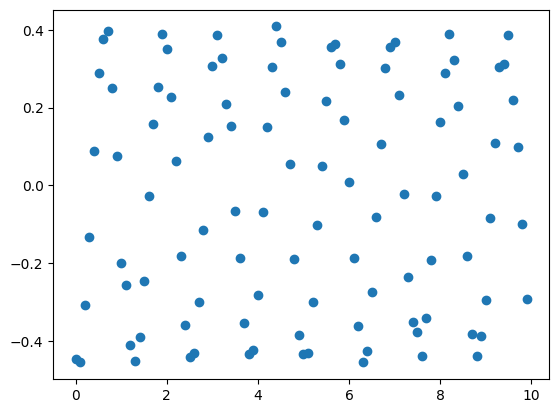

In [94]:
print(process_two_state_dual(run10Results3, "00000"))
plt.scatter(run1Range, process_two_state(run10Results3, "00000"))
plt.show()

[390, 325, 342, 358, 361, 352, 341, 345, 352, 311, 334, 357, 355, 361, 354, 365, 366, 349, 359, 338, 346, 340, 376, 355, 354, 347, 377, 353, 350, 366, 348, 349, 335, 352, 381, 373, 351, 345, 351, 346, 388, 353, 329, 323, 352, 336, 349, 353, 361, 343, 331, 363, 353, 320, 350, 330, 328, 364, 351, 330, 350, 353, 344, 362, 377, 372, 354, 344, 348, 362, 361, 355, 320, 355, 351, 335, 355, 354, 367, 355, 347, 356, 327, 336, 388, 351, 367, 307, 324, 363, 348, 342, 359, 361, 364, 360, 361, 354, 350, 346]
[-0.4743589743589743, -0.4523076923076924, -0.34795321637426907, -0.07541899441340782, 0.14127423822714688, 0.2755681818181819, 0.3812316715542522, 0.36811594202898557, 0.2414772727272728, 0.022508038585209028, -0.14071856287425144, -0.42296918767507, -0.4929577464788732, -0.5567867036011079, -0.4096045197740113, -0.32602739726027397, 0.0, 0.0515759312320917, 0.2339832869080779, 0.3017751479289942, 0.2774566473988439, 0.18529411764705883, -0.007978723404255261, -0.22535211267605626, -0.32203389

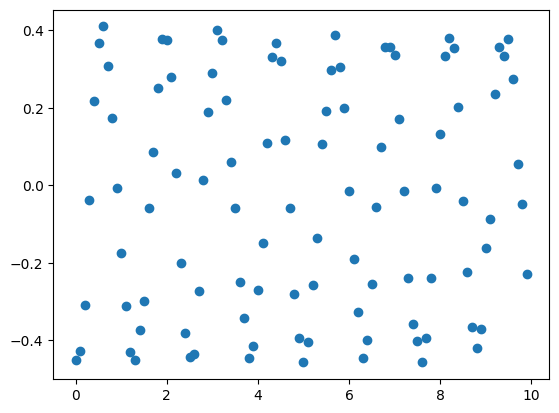

In [95]:
print(process_two_state_dual(run10Results4, "000000"))
plt.scatter(run1Range, process_two_state(run10Results4, "000000"))
plt.show()

[374, 340, 383, 351, 364, 376, 365, 372, 363, 399, 379, 370, 345, 388, 365, 378, 387, 358, 363, 379, 373, 371, 361, 373, 402, 356, 365, 338, 371, 365, 351, 357, 351, 342, 368, 393, 362, 384, 339, 365, 360, 376, 369, 348, 367, 383, 333, 365, 368, 375, 344, 368, 355, 386, 381, 356, 371, 353, 362, 383, 367, 386, 361, 372, 365, 346, 370, 397, 352, 334, 395, 341, 380, 374, 392, 344, 368, 372, 358, 373, 356, 367, 373, 361, 355, 350, 376, 369, 372, 385, 343, 370, 349, 377, 374, 361, 351, 349, 359, 353]
[-0.4919786096256684, -0.4088235294117647, -0.2898172323759792, -0.11396011396011396, 0.07142857142857148, 0.29255319148936165, 0.3671232876712329, 0.3978494623655914, 0.23691460055096425, 0.040100250626566414, -0.12928759894459096, -0.33513513513513504, -0.45507246376811594, -0.5025773195876289, -0.3616438356164384, -0.2063492063492064, -0.031007751937984523, 0.16480446927374304, 0.27548209366391185, 0.36939313984168864, 0.2654155495978553, 0.2048517520215634, -0.08033240997229918, -0.25469168

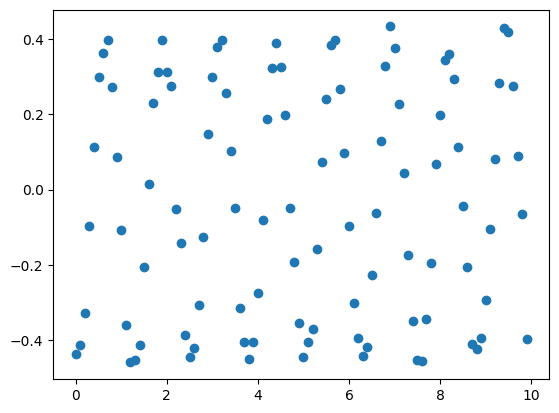

In [96]:
print(process_two_state_dual(run10Results5, "0000000"))
plt.scatter(run1Range, process_two_state(run10Results5, "0000000"))
plt.show()

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: 37bf87c6569e40fb85bd1be1df538073-16365684427928798
second pass w/ peaks:
[-1.0, 4.0]
second run job id: 08ac3e41242c463e940fe5a4fa3e204f-16365685470063767
done w/ second pass
[[[-1.5, 29.96], [-1.4500000000000002, 33.4], [-1.4, 31.2], [-1.35, 32.08], [-1.3, 33.8], [-1.25, 31.72], [-1.2000000000000002, 27.12], [-1.15, 62.6], [-1.1, 52.96], [-1.05, 127.64], [-1.0, 204.52], [-0.95, 149.72], [-0.9, 61.56], [-0.8500000000000001, 33.32], [-0.8, 33.28], [-0.75, 43.44], [-0.7, 46.24], [-0.65, 32.6], [-0.6, 32.08], [-0.55, 35.68], [-0.5, 37.28]], [[3.5, 44.4], [3.55, 29.44], [3.6, 37.52], [3.65, 38.0], [3.7, 40.72], [3.75, 27.8], [3.8, 41.36], [3.85, 66.6], [3.9, 75.04], [3.95, 159.08], [4.0, 204.44], [4.05, 132.16], [4.1, 63.64], [4.15, 47.84], [4.2, 31.76], [4.25, 27.0], [4.3, 23.84], [4.35, 42.24], [4.4, 38.36], [4.45, 33.8], [4.5, 37.56]]]


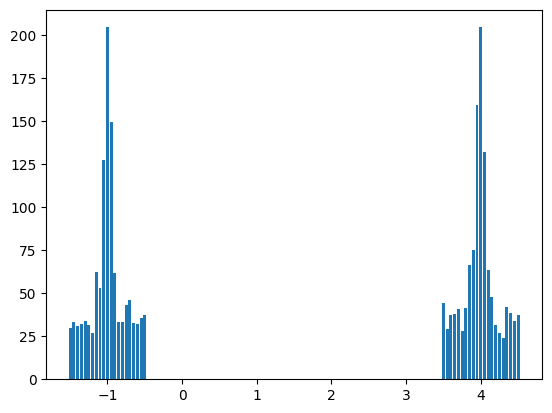

In [12]:
fiveCycle = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 5, 21, 25, 2.5, 1.5, backendJakarta), 1)
print(fiveCycle)
plot_scans(fiveCycle)

In [18]:
run11Job = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run11Job.job_set_id())
run11Results = run11Job.results()

08074e7d650643138c8a7aa7374a04bc-1637047850140956


[453, 434, 463, 459, 468, 465, 455, 461, 454, 483, 453, 476, 417, 425, 483, 474, 451, 461, 456, 453, 448, 457, 440, 475, 441, 467, 446, 462, 456, 449, 479, 419, 448, 453, 456, 466, 448, 470, 448, 455, 444, 461, 452, 434, 455, 443, 446, 423, 473, 440, 442, 453, 446, 465, 461, 455, 440, 465, 476, 449, 480, 477, 453, 460, 433, 455, 471, 425, 466, 438, 483, 460, 460, 464, 481, 434, 449, 446, 444, 435, 448, 449, 458, 469, 476, 444, 458, 412, 461, 459, 438, 444, 467, 427, 463, 447, 477, 452, 435, 441]
[-0.4922737306843266, -0.47695852534562216, -0.35205183585313177, -0.08932461873638342, 0.14316239316239313, 0.34838709677419355, 0.41538461538461546, 0.4490238611713666, 0.29074889867841414, 0.062111801242235976, -0.13024282560706402, -0.2836134453781513, -0.4100719424460432, -0.4376470588235294, -0.3581780538302277, -0.23839662447257381, 0.05321507760532154, 0.19956616052060736, 0.3157894736842105, 0.4370860927152318, 0.3258928571428571, 0.17067833698030632, -0.11818181818181817, -0.223157894

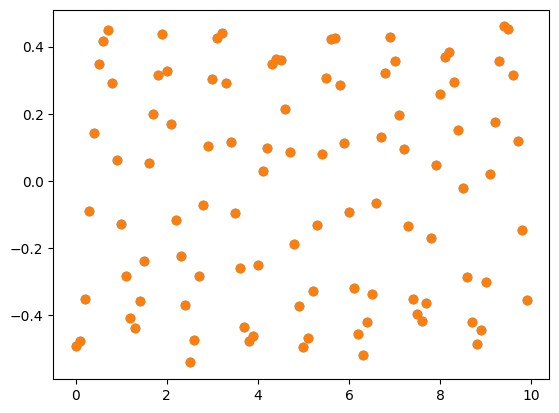

In [20]:
print(process_two_state_dual(run11Results, "00000"))
plt.scatter(run1Range, process_two_state_dual(run11Results, "00000"))
plt.show()

In [21]:
averageSuccesses = list()
times = []
state = '0'
for i in range(6):
    state = state + '0'
    times.append(np.random.normal(0, 7))
    circs = []
    for j in range(25):
        circs.append(run_rodeo(times, i+1, 4, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend)
    temp = 0
    for k in range(25):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/25
    averageSuccesses.append(temp)

In [23]:
#ids (1 up through 6):
#619361c01fe02d2167c3eea7
#619361e20fca888fe20f3768
#619361f9fc46da11868e725d
#619362169c22c3f1cee61a24
#6193622b0b2c1277b1701458
#619362444633b702742235fb

print(averageSuccesses)

[644.6, 493.56, 248.28, 113.24, 87.12, 58.16]


In [26]:
averageSuccesses2 = list()
times = []
state = '0'
for i in range(6):
    state = state + '0'
    times.append(np.random.normal(0, 7))
    circs = []
    for j in range(25):
        circs.append(run_rodeo(times, i+1, 2.5, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(25):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/25
    averageSuccesses2.append(temp)

job: 1
84711b3e56f449dc9579f7468b8cd6ff-163704998959255
job: 2
d0794fba60424ebdaf4575a1569e3dae-16370500839235544
job: 3
6861e92acce94ef4aa83a6b8a56e8d70-163705010457876
job: 4
2bd0c45e86ec44a0be02027147c33b4d-16370501583886209
job: 5
8dd98c6866524ff6878e0813ad6b2d8b-163705018155113
job: 6
61bff71621bb4a73a102602729c6df5a-16370502049272296


In [27]:
print(averageSuccesses2)

[508.24, 296.04, 52.28, 26.32, 12.88, 6.8]


In [15]:
averageSuccesses3 = list()
times = []
state = '0'

jobs = list()

jobs.append(jobManager.retrieve_job_set('0e56a8df1b224e4f92b18ca855104744-16372231264776256', provider))
jobs.append(jobManager.retrieve_job_set('63302af4e3fe40ad8910e2ae6d380c4c-16372249336051407', provider))
jobs.append(jobManager.retrieve_job_set('6395aa665d78446286670d913b9f2076-16372259460399103', provider))
jobs.append(jobManager.retrieve_job_set('48568c9bc07c4368bbb086b9a71854da-16372273729760299', provider))
jobs.append(jobManager.retrieve_job_set('9bec5554c33f4490af279f794b2cf32c-1637249220195117', provider))
jobs.append(jobManager.retrieve_job_set('9aa760561b164f5bbfb152b3b123877f-1637288351876479', provider))
for job in jobs:
    state = state + '0'
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses3.append(temp)
print("done with -1")
print(averageSuccesses3)

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjobset.py:195: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  experiments_count=len(job.qobj().experiments),


done with -1
[769.0498046875, 388.673828125, 230.4833984375, 143.1318359375, 81.1552734375, 50.728515625]


In [19]:
averageSuccesses4 = list()
state = '0'
times = []
jobs = []

jobs.append(jobManager.retrieve_job_set('2f09f0c2d91f4e4d8d34293b803058f0-16372961681295235', provider))
jobs.append(jobManager.retrieve_job_set('5745882d47ed46c88950fbdebe985d89-1637297152964673', provider))
jobs.append(jobManager.retrieve_job_set('13fe7dda81dd4920af4cba9b951fe01e-16372986311821728', provider))
jobs.append(jobManager.retrieve_job_set('316f45cc39844f6087174f1d2a70cdce-1637308077648706', provider))
jobs.append(jobManager.retrieve_job_set('eefbc8c1eebe4f2396018cb0f1859ea5-16373402735990226', provider))

for i in range(6):
    times.append(np.random.normal(0,7))

circs = []
for i in range(1024):
    circs.append(run_rodeo(times, 6, 4, 2.5, 1.5))
circs = transpile(circs, backend=backend)
print('running job 6')
jobs.append(jobManager.run(circs, backend=backend))
print(jobs[5].job_set_id())

for job in jobs:
    state = state + '0'
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses4.append(temp)
print("done with 4")
print(averageSuccesses4)

running job 6
e289686fe44042dc8750e6666404bd9d-16373468899512572
done with 4
[891.8251953125, 568.8251953125, 348.107421875, 289.6630859375, 226.8125, 53.8662109375]


In [20]:
averageSuccesses5 = list()
times = []
state = '0'
for i in range(6):
    state = state + '0'
    times.append(np.random.normal(0, 7))
    circs = []
    for j in range(1024):
        circs.append(run_rodeo(times, i+1, 0, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses5.append(temp)
print("done with 0")
print(averageSuccesses5)

job: 1
7831710778854a80bb8cf84f36a75c96-16373486879670866
job: 2
b2e99bcd3a1740e993143153c6c25cde-1637349096627502
job: 3
7d328130b1a04aaa8690f74905a5cbb1-1637349544450923
job: 4
d893b6f43e1d4e5bbee02ce8f33490db-16373500005959709
job: 5
bb57a7873d994b34a2973118c4e3f920-16373506392842793
job: 6
ddc50af8a8ab44b29cfa1d9155514a36-163735130612608
done with 0
[415.205078125, 212.314453125, 73.693359375, 46.95703125, 40.6181640625, 31.013671875]


In [23]:
averageSuccesses6 = list()
state = '0'
for i in range(6):
    state = state + '0'
    circs = []
    for j in range(1024):
        times = []
        for k in range(i+1):
            times.append(np.random.normal(0, 7))
        circs.append(run_rodeo(times, i+1, -1, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses6.append(temp)
print("done with -1")
print(averageSuccesses6)

job: 1
d32af01c8bdb41b092df59eb175e1202-16373548709481738
job: 2
1c9c816dcdb441c19c4e0ca2f3aee739-16373602292860484
job: 3
89f1bdec4b274668a05da21f136ab991-16373610499465005
job: 4
1ce0b0568905410eb435918cc4a055d4-16373616630527878
job: 5
cc5d9fb5edf34253973b0942c039ff4b-16373622403380942
job: 6
62660a8254ef4c8e9eab112e86b9dcea-16373628326656618
done with -1
[622.662109375, 390.0224609375, 257.7216796875, 160.5986328125, 111.056640625, 72.1279296875]


In [25]:
averageSuccesses7 = list()
state = '0'
for i in range(6):
    state = state + '0'
    circs = []
    for j in range(1024):
        times = []
        for k in range(i+1):
            times.append(np.random.normal(0, 7))
        circs.append(run_rodeo(times, i+1, 4, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses7.append(temp)
print("done with 4")
print(averageSuccesses7)

job: 1
b294b7e9c7f14f03914bb5899b24c23b-16373637220239582
job: 2
26b8ae8e91914229a33009e3da7f1f3b-16373641766786351
job: 3
47b365ec5b11449bafa915d601e8fbd2-1637364823196747
job: 4
93cca31966b74ab29b2932306024bf95-1637365345773776
job: 5
9ac35cc34c2644ef822901e9cd2e1f4f-16373658722231896
job: 6
af45901057e14777b472b415d34a2112-163736684298813
done with -1
[628.5693359375, 396.435546875, 255.62109375, 176.9287109375, 111.21484375, 79.01953125]
job: 1
9855b76ac46941038737a7831058032b-16373674865824015


C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjob.py:202: UserWarning: Unable to retrieve job result for experiments 0-299, job ID=61983ebf68476d36708a754c: 'Unable to retrieve result for job 61983ebf68476d36708a754c. Job was cancelled.' 
  warnings.warn(
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjob.py:202: UserWarning: Unable to retrieve job result for experiments 300-599, job ID=61983ec2580e75335014e1ef: 'Unable to retrieve result for job 61983ec2580e75335014e1ef. Job was cancelled.' 
  warnings.warn(
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjob.py:202: UserWarning: Unable to retrieve job result for experiments 600-899, job ID=61983ec41db79f776fda279c: 'Unable to retrieve result for job 61983ec41db79f776fda279c. Job was cancelled.' 
  warnings.warn(
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\manag

IBMQManagedResultDataNotAvailable: 'Result data for experiment 0 is not available.'

In [26]:
averageSuccesses8 = list()
state = '0'
for i in range(6):
    state = state + '0'
    circs = []
    for j in range(1024):
        times = []
        for k in range(i+1):
            times.append(np.random.normal(0, 7))
        circs.append(run_rodeo(times, i+1, 0, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses8.append(temp)
print("done with 0")
print(averageSuccesses8)

job: 1
39bfe00bccae479aaf5c2033d95a9cb2-16373675615539527
job: 2
cbace1a099ac40b4ad9e2fa73931b06e-16373680348038223
job: 3
b0a161b4c8f54181b8edb7505a6f858a-16373685873499124
job: 4
894c6514321f435f87df842045b2ed97-16373694147475128
job: 5
bb37c346d5f64b79bee57729dbb5dea2-16373699478942406
job: 6
7e319ee32461410292bedcc692df2eac-1637370509874053
done with 0
[504.140625, 256.65234375, 129.1337890625, 67.4716796875, 36.1748046875, 15.171875]


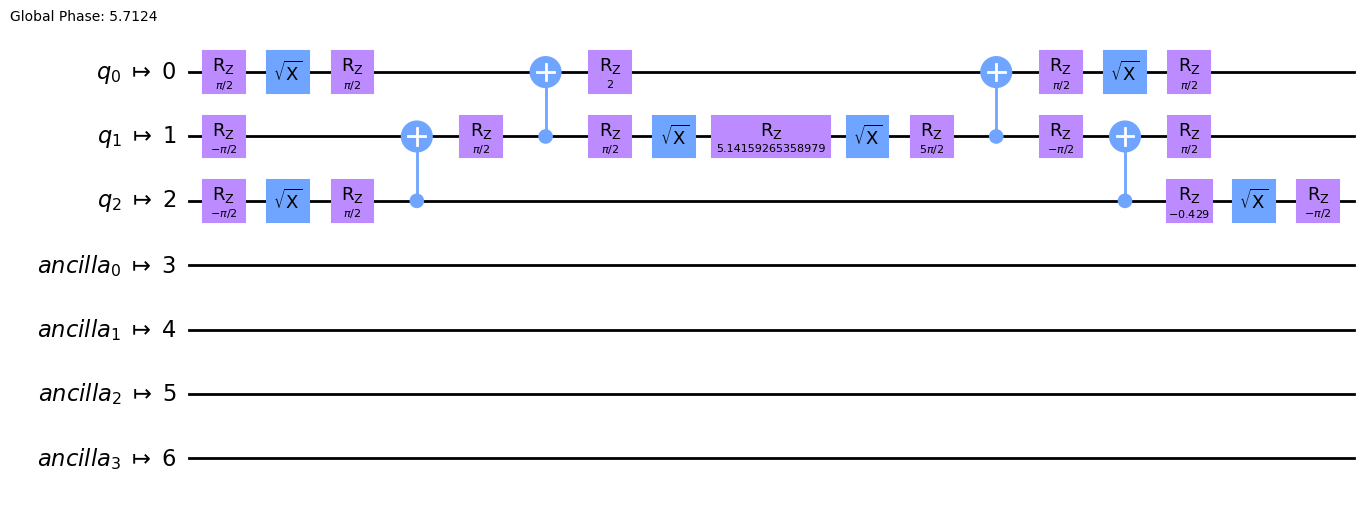

In [34]:
test = make_cycle(1, 1, 1, 1)
test = transpile(test, backend)
test.draw('mpl')

In [27]:
mods = np.random.default_rng(42)

prodXMod = (mods.random() - 0.5) * 10
prodZMod = (mods.random() - 0.5) * 10
print(prodXMod)
print(prodZMod)

2.7395604855596334
-0.6112156024794768


first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: 3aebd200e01542d18ecb8e352a55a146-16382619247297838
second pass w/ peaks:
[-5.0, -3.0, -2.0, 2.0, 3.0, 5.0]
second run job id: 49ebab28efb84b6f89edd381e971dfae-1638262105883612
done w/ second pass


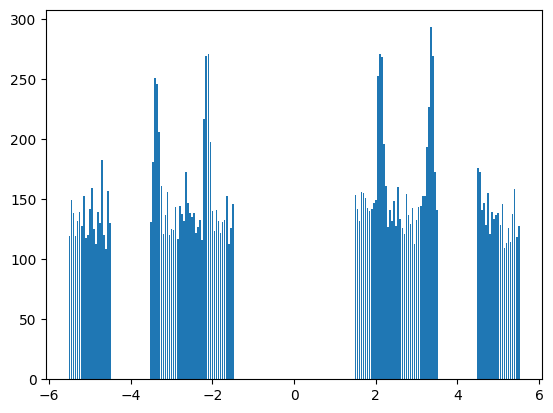

In [32]:
testRun = search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, prodXMod, prodZMod, backendJakarta)
testRunData = process_data(testRun, 1)
plot_scans(testRunData)

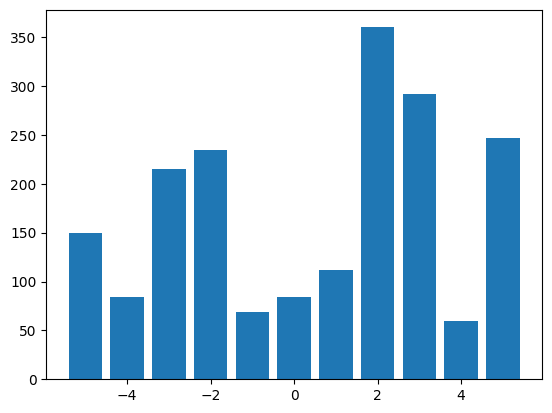

In [33]:
plot_scans(process_data(testRun, 0))